In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Library

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import random
import statistics
import math
from collections import Counter

import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.sandbox.stats.multicomp import MultiComparison
from scipy.stats import chi2_contingency
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%matplotlib inline

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Data

In [3]:
# 2010 Census Tract: https://www.census.gov/geographies/reference-files/2010/geo/relationship-files.html#par_textimage_674173622
# 2018 SVI: https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html
# Google Colab file path
#file_path_patient = "/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/Seton COVID Cohort Dataset Share SDH/covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
#file_path_patient_extra = "/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/Seton COVID Cohort Dataset Share SDH/meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
#file_path_zip = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/zip_code_data.csv'
#file_path_census_tract = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/zcta_tract_rel_10.txt'
#file_path_svi_tx = '/content/drive/MyDrive/UT Austin/Research/HAI_Lab_Dr. Lee/COVID/datasets/Texas.csv'

# Local file path

file_path_patient = "/content/drive/MyDrive/Colab Notebooks/allocation-vent/Seton COVID Cohort Dataset Share SDH/covid_pts_enc_level_labs_dx_2021-02-02_deid.csv"
file_path_patient_extra = "/content/drive/MyDrive/Colab Notebooks/allocation-vent/Seton COVID Cohort Dataset Share SDH/meds_admin_for_SOFA_COVID_cohort_SDH_share.csv"
file_path_zip_tx = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/zip_code_data.csv'
file_path_census_tract = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/zcta_tract_rel_10.txt'
file_path_svi_tx = '/content/drive/MyDrive/Colab Notebooks/allocation-vent/datasets/Texas.csv'

df = pd.read_csv(file_path_patient, index_col=False)
df_extra = pd.read_csv(file_path_patient_extra, index_col=False)
df_zip_tx = pd.read_csv(file_path_zip_tx, index_col=False)
df_census_tract = pd.read_csv(file_path_census_tract, index_col=False)
df_svi_tx = pd.read_csv(file_path_svi_tx)

# Functions

In [4]:
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score
# https://www.mdcalc.com/sequential-organ-failure-assessment-sofa-score#evidence
# https://ccforum.biomedcentral.com/articles/10.1186/s13054-019-2663-7
# # https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Week-and-County-Soc/9hdi-ekmb
# https://pubmed.ncbi.nlm.nih.gov/34397917/

calibration_sofa_mortality = {
    0: 0.0,
    1: 0.0,
    2: 6.4,
    3: 6.4,
    4: 20.2,
    5: 20.2,
    6: 21.5,
    7: 21.5,
    8: 33.3,
    9: 33.3,
    10: 50.0,
    11: 50.0,
    12: 95.2,
    13: 95.2,
    14: 95.2,
    15: 95.2,
    16: 95.2,
    17: 95.2,
    18: 95.2,
    19: 95.2,
    20: 95.2,
    21: 95.2,
    22: 95.2,
    23: 95.2,
    24: 95.2
}

def calculate_sofa(patient):    # Calculate SOFA scores
    score = 0
    
    # 1. Respiratory system: PaO2/FiO2 (mmHg)
    if (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 300 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 399:
        score += 1 
        
    elif ((patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 200 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 299) or ((patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] == np.nan):
        score += 2
        
    #elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'].notnull() == True:
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 >= 100 and (patient['pO2_Art']/patient['FiO2/Percent'])*100 <= 199 and patient['vent_hours_summed'] != np.nan:
        score += 3
        
    elif (patient['pO2_Art']/patient['FiO2/Percent'])*100 < 100 and patient['vent_hours_summed'] != np.nan:
        score += 4
        
    # 2. Nervous system: Glasgow Coma Scale
    if patient['Glasgow_Coma_Score'] == 13 or patient['Glasgow_Coma_Score'] == 14:
        score += 1 
        
    elif patient['Glasgow_Coma_Score'] >= 10 and patient['Glasgow_Coma_Score'] <= 12:
        score += 2
        
    elif patient['Glasgow_Coma_Score'] >= 6 and patient['Glasgow_Coma_Score'] <= 9:
        score += 3
        
    elif patient['Glasgow_Coma_Score'] < 6:
        score += 4
    
    # 3. Cardiovascular system: Mean arterial pressure (MAP) OR administration of vasopressors required
    if patient['Mean_Arterial_Pressure'] < 70:
        score += 1 
    
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] <= 5) or (patient['medication_name']=='dobuTamine' and patient['dose_of_medication'] !=np.nan):
        score += 2

    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 5 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] <= 0.1)or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] <= 0.1):
        score += 3
   
    elif (patient['medication_name']=='dopamine' and patient['dose_of_medication'] > 15 and patient['medication_name']=='epinephrine' and patient['dose_of_medication'] > 0.1) or (patient['medication_name']=='norepinephrine' and patient['dose_of_medication'] > 0.1):
        score += 4

    # 4. Liver: Bilirubin (mg/dl) [μmol/L] 
    if float(patient['Bili_Total']) >= 1.2 and float(patient['Bili_Total']) <= 1.9:
        score += 1 
        
    elif float(patient['Bili_Total']) >= 2.0 and float(patient['Bili_Total']) <= 5.9:
        score += 2
        
    elif float(patient['Bili_Total']) >= 6.0 and float(patient['Bili_Total']) <= 11.9:
        score += 3
        
    elif float(patient['Bili_Total']) >= 12.0:
        score += 4

    # 5. Coagulation: Platelets ×103/ml
    if patient['Platelet'] >= 100 and patient['Platelet'] < 150:
        score += 1 
        
    elif patient['Platelet'] >= 50 and patient['Platelet'] < 100:
        score += 2
        
    elif patient['Platelet'] >= 20 and patient['Platelet'] < 50:
        score += 3
        
    elif patient['Platelet'] < 20:
        score += 4
        
    # 6. Kidneys: Creatinine (mg/dl) [μmol/L]; urine output
    if patient['Creatinine'] >= 1.2 and patient['Creatinine'] <= 1.9:
        score += 1 
        
    elif patient['Creatinine'] >= 2.0 and patient['Creatinine'] <= 3.4:
        score += 2
        
    elif patient['Creatinine'] >= 3.5 and patient['Creatinine'] <= 4.9:
        score += 3
        
    elif patient['Creatinine'] >= 5.0:
        score += 4 
    
    return score

def count_comorbidity(patient): # Calculate comorbidity conditions
    count = 0 
    
    if patient.COPD_com_flag == 1:
        count += 1 
        
    if patient.asthma_com_flag == 1:
        count += 1 
        
    if patient.diabetes_com_flag == 1:
        count += 1 
        
    if patient.hypertension_com_flag == 1:
        count += 1 
        
    if patient.CAD_com_flag == 1:
        count += 1 
        
    if patient.heartfailure_com_flag == 1: 
        count += 1 
        
    if patient.CKD_com_flag == 1:
        count += 1 
        
    if patient.cancer_com_flag == 1:
        count += 1 
        
    return count

def percentage_death(race): # Calculate percentage of deaths for each race
    count = count_race[race.race] # Number of patients in their racial groups

    return (race.count_death / count) * 100

ls_race = ['White', 'Black or African American', 'Hispanic or Latino', 'Asian']
def latinx(patient):    # Clean up race/ethnicity
    if patient['ethnicity_display'] == 'Hispanic or Latino' and patient['race_display'] == 'White':
        return "Hispanic or Latino"
    elif patient['ethnicity_display'] == 'Not Hispanic or Latino' and patient['race_display'] == 'White': 
        return "White"
    elif patient['race_display'] == 'Hispanic':
        return "Hispanic or Latino"
    else:
        return patient['race_display']

ls_svi = ['Low', 'Moderate', 'High']
def categorize_svi(patient):    # Clean up race/ethnicity
    if patient['RPL_THEMES'] < 0:
        return "Unknown"
    elif patient['RPL_THEMES'] >= 0 and patient['RPL_THEMES'] <= 0.333: 
        return "Low"
    elif patient['RPL_THEMES'] >= 0.334 and patient['RPL_THEMES'] <= 0.666: 
        return "Moderate"
    elif patient['RPL_THEMES'] >= 0.667 and patient['RPL_THEMES'] <= 1: 
        return "High"

# Exploratory Data Anlaysis (EDA)

## Data: Main

In [5]:
print(df.shape)
print('Number of unique encounters: {}'.format(df['deid_fin_encounter'].nunique()))
df.head()

(2469, 70)
Number of unique encounters: 2469


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,4dMaH,61003,10650
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,False,False,False,False,False,False,False,False,3.0,8wQnr,84969,27818
2,2020-03-25 13:25:00,2020-03-30 03:48:00,Medical Center,IP Private/Semi Private room,80,Female,78758,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,4.58,A41.89,3/30/2020 3:48,Expired,Expired,Insured,Emergency room,Ambulance,NaN,NaN,NaN,NaN,NaN,NaN,Not employed,Not employed,Not employed,1.2,1.8,18,87.0,0.2,NaN,77.0,90.100,NaN,11.0,12.4,Nasal cannula,NaN,556.0,130.1,NaN,20.0,110.0,0.2,14.3,4.0,Unknown if ever smoked,AMS,NaN,NaN,NaN,NaN,125.0,NaN,NaN,False,False,False,True,False,True,True,True,False,1.0,6YGuu,69112,34412
3,2020-03-25 13:36:00,2020-03-27 13:15:00,Medical Center,IP Private/Semi Private room,56,Male,78746,Not Hispanic or Latino,White,White Non Hispanic,2.00,R19.7,NaN,Home,Home,Insured,Emergency room,Private Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,Chef,Restaurant,Employed,0.9,0.9,31,30.0,0.9,<200,89.0,84.368,NaN,15.0,10.6,Room air,92.0,193.0,NaN,0.04,38.0,144.0,NaN,8.2,2.0,Never smoker,diarrhea,70.0,107.3,NaN,NaN,86.0,38.4,26.687783,False,False,False,False,False,False,False,False,False,1.0,P1Tjg,84820,37981
4,2020-03-25 13:43:00,2020-03-27 12:44:00,Medical Center,IP Private/Semi Private room,46,Female,78757,Not Hispanic or Latino,White,White Non Hispanic,1.96,J12.89,NaN,Home,Home,Insured,Emergency room,Private Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,Newspaper,Other,Employed,0.8,1.7,25,37.0,0.7,NaN,78.0,99.500,NaN,15.0,33.2,Room air,95.0,184.0,NaN,0.04,18.0,117.0,NaN,5.1,NaN,Never smoker,poss covid asthma,66.0,91.0,NaN,NaN,82.0,37.3,35.410000,False,False,True,False,False,False,False,False,False,0.0,iouKO,76686,41152


In [6]:
df.loc[df['icu_hours_summed'].notnull()].shape

(741, 70)

In [7]:
df.loc[df['icu_hours_summed'].notnull(), ['vent_hours_summed']].value_counts(dropna=False)

vent_hours_summed
NaN                  446
0.02                   3
0.25                   2
0.00                   2
0.05                   1
                    ... 
160.72                 1
159.50                 1
159.38                 1
154.90                 1
288.35                 1
Length: 292, dtype: int64

In [8]:
df.loc[df["icu_hours_summed"].notnull(), ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1).value_counts()

Hispanic or Latino                          369
White                                       252
Black or African American                    61
Other Race                                   27
Unknown                                      16
Asian                                         7
American Indian/Alaska Native                 4
Decline to Specify                            4
Native Hawaiian or Other Pacific Islande      1
dtype: int64

In [9]:
df.loc[(df['icu_hours_summed'].notnull()) & (df["vent_hours_summed"].notnull()), ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1).value_counts()

Hispanic or Latino               156
White                             85
Black or African American         25
Other Race                        12
Unknown                            8
Decline to Specify                 4
Asian                              3
American Indian/Alaska Native      2
dtype: int64

In [10]:
df['race'] = df.loc[:, ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1)
df['race'].value_counts()

Hispanic or Latino                          1197
White                                        827
Black or African American                    242
Other Race                                    91
Unknown                                       50
Asian                                         27
Decline to Specify                            18
American Indian/Alaska Native                 12
Native Hawaiian or Other Pacific Islande       5
Name: race, dtype: int64

### Age

Average age of patients: 53.89
Variance of age of patients: 397.69
Standard deviation of age of patients: 19.94


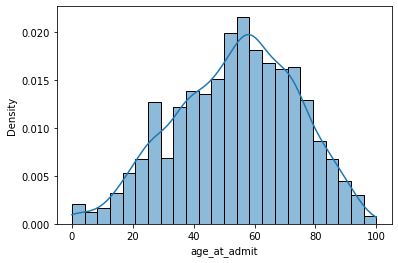

In [11]:
print('Average age of patients: {}'.format(round(df['age_at_admit'].mean(),2)))
print('Variance of age of patients: {}'.format(round(df['age_at_admit'].var(),2)))
print('Standard deviation of age of patients: {}'.format(round(df['age_at_admit'].std(),2)))
sns.histplot(data=df, x='age_at_admit', stat='density', kde=True)

Average age of White patients: age_at_admit    57.89
dtype: float64
Variance of age of White patients: age_at_admit    393.71
dtype: float64
Standard deviation of age of White patients: age_at_admit    19.84
dtype: float64


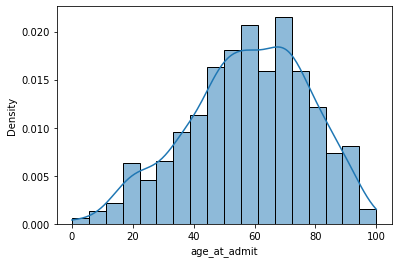

In [12]:
print('Average age of {} patients: {}'.format('White', round(df.loc[df['race']=='White', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('White', round(df.loc[df['race']=='White', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('White', round(df.loc[df['race']=='White', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='White'], x='age_at_admit', stat='density', kde=True)

Average age of Hispanic or Latino patients: age_at_admit    51.22
dtype: float64
Variance of age of Hispanic or Latino patients: age_at_admit    373.56
dtype: float64
Standard deviation of age of Hispanic or Latino patients: age_at_admit    19.33
dtype: float64


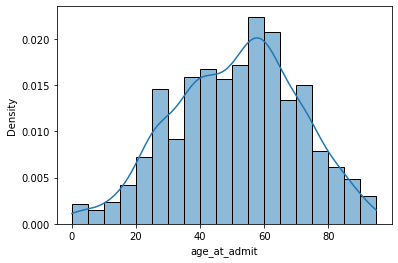

In [13]:
print('Average age of {} patients: {}'.format('Hispanic or Latino', round(df.loc[df['race']=='Hispanic or Latino', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('Hispanic or Latino', round(df.loc[df['race']=='Hispanic or Latino', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('Hispanic or Latino', round(df.loc[df['race']=='Hispanic or Latino', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='Hispanic or Latino'], x='age_at_admit', stat='density', kde=True)

Average age of Black or African American patients: age_at_admit    56.32
dtype: float64
Variance of age of Black or African American patients: age_at_admit    453.2
dtype: float64
Standard deviation of age of Black or African American patients: age_at_admit    21.29
dtype: float64


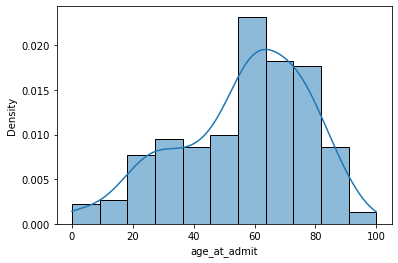

In [14]:
print('Average age of {} patients: {}'.format('Black or African American', round(df.loc[df['race']=='Black or African American', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('Black or African American', round(df.loc[df['race']=='Black or African American', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('Black or African American', round(df.loc[df['race']=='Black or African American', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='Black or African American'], x='age_at_admit', stat='density', kde=True)

Average age of Asian patients: age_at_admit    47.67
dtype: float64
Variance of age of Asian patients: age_at_admit    313.23
dtype: float64
Standard deviation of age of Asian patients: age_at_admit    17.7
dtype: float64


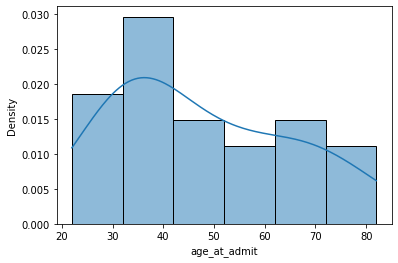

In [15]:
print('Average age of {} patients: {}'.format('Asian', round(df.loc[df['race']=='Asian', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('Asian', round(df.loc[df['race']=='Asian', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('Asian', round(df.loc[df['race']=='Asian', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='Asian'], x='age_at_admit', stat='density', kde=True)

Average age of American Indian/Alaska Native patients: age_at_admit    43.33
dtype: float64
Variance of age of American Indian/Alaska Native patients: age_at_admit    187.88
dtype: float64
Standard deviation of age of American Indian/Alaska Native patients: age_at_admit    13.71
dtype: float64


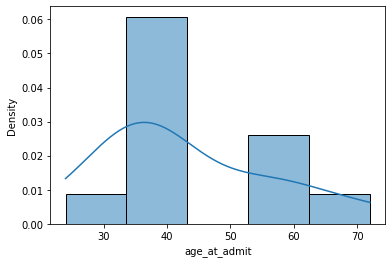

In [16]:
print('Average age of {} patients: {}'.format('American Indian/Alaska Native', round(df.loc[df['race']=='American Indian/Alaska Native', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('American Indian/Alaska Native', round(df.loc[df['race']=='American Indian/Alaska Native', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('American Indian/Alaska Native', round(df.loc[df['race']=='American Indian/Alaska Native', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='American Indian/Alaska Native'], x='age_at_admit', stat='density', kde=True)

Average age of Native Hawaiian or Other Pacific Islande patients: age_at_admit    60.2
dtype: float64
Variance of age of Native Hawaiian or Other Pacific Islande patients: age_at_admit    135.7
dtype: float64
Standard deviation of age of Native Hawaiian or Other Pacific Islande patients: age_at_admit    11.65
dtype: float64


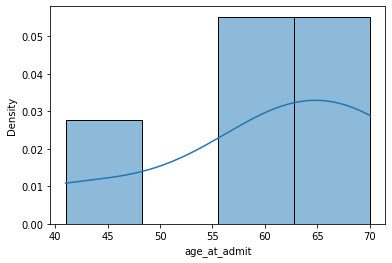

In [17]:
print('Average age of {} patients: {}'.format('Native Hawaiian or Other Pacific Islande', round(df.loc[df['race']=='Native Hawaiian or Other Pacific Islande', ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('Native Hawaiian or Other Pacific Islande', round(df.loc[df['race']=='Native Hawaiian or Other Pacific Islande', ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('Native Hawaiian or Other Pacific Islande', round(df.loc[df['race']=='Native Hawaiian or Other Pacific Islande', ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race']=='Native Hawaiian or Other Pacific Islande'], x='age_at_admit', stat='density', kde=True)

Average age of Unknown patients: age_at_admit    51.14
dtype: float64
Variance of age of Unknown patients: age_at_admit    396.18
dtype: float64
Standard deviation of age of Unknown patients: age_at_admit    19.9
dtype: float64


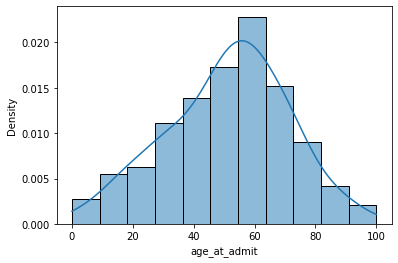

In [18]:
print('Average age of {} patients: {}'.format('Unknown', round(df.loc[df['race'].isin(['Unknown', 'Other Race', 'Decline to Specify']), ['age_at_admit']].mean(),2)))
print('Variance of age of {} patients: {}'.format('Unknown', round(df.loc[df['race'].isin(['Unknown', 'Other Race', 'Decline to Specify']), ['age_at_admit']].var(),2)))
print('Standard deviation of age of {} patients: {}'.format('Unknown', round(df.loc[df['race'].isin(['Unknown', 'Other Race', 'Decline to Specify']), ['age_at_admit']].std(),2)))
sns.histplot(data=df.loc[df['race'].isin(['Unknown', 'Other Race', 'Decline to Specify'])], x='age_at_admit', stat='density', kde=True)

In [19]:
print('Average length of stay in encounter: {}'.format(round(df["length_of_stay"].mean(), 2)))
print('Standard deviation length of stay in encounter: {}'.format(round(df["length_of_stay"].std(), 2)))

Average length of stay in encounter: 7.59
Standard deviation length of stay in encounter: 10.63


In [20]:
print("Number of ICU patients: {}".format(df.loc[df['icu_hours_summed'].notnull()].shape[0]))
print("Number of ICU patients allocated to vents: {}".format(df.loc[(df['icu_hours_summed'].notnull()) & (df["vent_hours_summed"].notnull())].shape[0]))

Number of ICU patients: 741
Number of ICU patients allocated to vents: 295


In [21]:
df.groupby(["race_display"]).agg({"deid_fin_encounter": "count"})

,deid_fin_encounter
race_display,
American Indian/Alaska Native,12
Asian,27
Black or African American,242
Decline to Specify,18
Hispanic,1
Native Hawaiian or Other Pacific Islande,5
Other Race,91
Unknown,50
White,2023


## Data: Extra

In [22]:
print(df_extra.shape)
df_extra.head()

(33892, 5)


,medication_name,dose_of_medication,administration_dt_tm,SOFA,deid_fin_encounter
0,norepinephrine,0.030122 mg,2020-08-03T09:59:59.000-05:00,NaN,35541
1,norepinephrine,0.11296 mg,2020-08-02T23:59:59.000-05:00,NaN,35541
2,norepinephrine,0.077088 mg,2020-08-02T22:59:59.000-05:00,NaN,35541
3,norepinephrine,mcg/kg/min,2020-08-03T09:15:00.000-05:00,NaN,35541
4,norepinephrine,0.080864 mg,2020-08-03T05:59:59.000-05:00,NaN,35541


## Data: Zip code

In [23]:
print(df_zip_tx.shape)
df_zip_tx.head()

(1935, 6)


,zip_code,male_poverty_rate,female_poverty_rate,median_income,mean_income,poverty_rate
0,ZCTA5 75001,3.8,11.4,72512,87472,10.9
1,ZCTA5 75002,1.4,5.2,101429,125779,4.9
2,ZCTA5 75006,2.1,12.3,64462,85788,10.8
3,ZCTA5 75007,1.8,6.6,86648,102783,6.7
4,ZCTA5 75009,1.2,6.1,111146,144513,4


In [24]:
df_zip_tx['zip_code'] = df_zip_tx['zip_code'].apply(lambda row: row.strip('ZCTA5 '))

ls_zip_error = []   
for code in df_zip_tx['zip_code']: # There zip codes that are not 5-digit number
    if len(code) != 5:
        ls_zip_error.append(code)

print("All zip codes: {}".format(len(df_zip_tx)))
print("Normal zip codes (5-digit): {}".format(len(df_zip_tx)-len(ls_zip_error)))
print('Abnormal zip codes (Non 5-digit): {}'.format(len(ls_zip_error)))

All zip codes: 1935
Normal zip codes (5-digit): 1744
Abnormal zip codes (Non 5-digit): 191


## Data: Census tract

In [25]:
# https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-census-tract-record-layout.html

# Extract only data from Texas state(=48)
df_census_tract_tx = df_census_tract.loc[df_census_tract['STATE']==48].copy()
df_census_tract_tx.reset_index(drop=True, inplace=True)

print(df_census_tract_tx.shape)
df_census_tract_tx.head()

# Extract only data from Texas state Travis county
# df_census_tract_tx_travis = df_census_tract.loc[(df_census_tract['STATE']==48) & (df_census_tract['COUNTY']==453)].copy()

(10009, 25)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,73949,48,421,950200,48421950200,410,190,287805986,287805986,1688,764,1366353259,1360361346,3034,1252,2391079318,2390650564,24.29,24.87,21.06,21.16,13.51,15.18,12.04,12.04
1,75001,48,113,13616,48113013616,4152,3223,2014512,2014512,12414,8102,9940470,9931768,5611,4018,3630263,3630263,33.45,39.78,20.27,20.28,74.00,80.21,55.49,55.49
2,75001,48,113,13725,48113013725,0,0,247511,247511,12414,8102,9940470,9931768,3615,1909,1839456,1839456,0.00,0.00,2.49,2.49,0.00,0.00,13.46,13.46
3,75001,48,113,13726,48113013726,2673,1488,1593774,1585072,12414,8102,9940470,9931768,2673,1488,1593774,1585072,21.53,18.37,16.03,15.96,100.00,100.00,100.00,100.00
4,75001,48,113,13727,48113013727,3231,1983,4937525,4937525,12414,8102,9940470,9931768,3235,1984,5171932,5171932,26.03,24.48,49.67,49.71,99.88,99.95,95.47,95.47


In [26]:
ls_zip = list(df_zip_tx["zip_code"].unique())
print("ZIP codes in df_zip_tx: {}".format(len(ls_zip)))

ls_cenus_tract_zip = list(df_census_tract_tx["ZCTA5"].unique())
print("ZIP codes in df_census_tract_tx: {}".format(len(ls_cenus_tract_zip)))

ZIP codes in df_zip_tx: 1935
ZIP codes in df_census_tract_tx: 1939


## Data: Social Vulnerable Index

In [27]:
# https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

df_svi_tx.reset_index(drop=True, inplace=True)

print(df_svi_tx.shape)
df_svi_tx.head()

# Extract only data from Travis county.
#df_svi_tx_travis = df_svi.loc[df_svi['COUNTY']=='Travis'].copy()

(5254, 124)


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,48,TEXAS,TX,48001,Anderson,48001950100,"Census Tract 9501, Anderson County, Texas",186.605851,5164,525,2455,131,1846,154,827,358,65,65,26849,2826,386,129,1003,137,1368,290,729,154,137,76,1045,703,60,94,20,16,642,132,100,45,46,35,48,22,16.2,6.3,3.1,3.1,26849.0,2826.0,10.9,3.5,19.4,2.9,26.5,4.9,14.2,3.0,7.4,4.1,20.2,13.5,1.3,2.0,0.8,0.7,26.2,4.9,5.4,2.4,2.5,1.8,0.9,0.4,0.5715,0.2288,0.4628,0.3743,1.6374,0.3853,0.8485,0.5530,0.6637,0.3648,2.4300,0.7610,0.1077,0.2085,0.3162,0.1308,0.2846,0.9075,0.6370,0.3280,0.7383,2.8954,0.7545,7.2790,0.4965,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,606,199,11.8,3.7,3098
1,48,TEXAS,TX,48001,Anderson,48001950401,"Census Tract 9504.01, Anderson County, Texas",6.389922,4872,263,96,28,81,30,3,5,0,13,2520,659,1061,147,49,34,136,62,12,12,8,18,3140,348,36,56,0,18,8,14,5,14,0,13,4575,261,1.0,1.6,0.0,28.6,2520.0,659.0,25.4,3.0,1.0,0.7,2.8,1.3,4.0,4.2,9.9,22.4,64.4,6.3,0.7,1.2,0.0,19.2,8.3,13.8,6.2,18.1,0.0,36.4,93.9,1.7,0.0100,0.0000,0.9989,0.7269,1.7358,0.4162,0.0098,0.0084,0.0280,0.5241,0.5703,0.0230,0.5744,0.1259,0.7003,0.3439,0.0000,0.7111,0.6899,0.0000,0.9958,2.3968,0.5421,5.4032,0.2477,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2,64,50,21.5,13.6,4344
2,48,TEXAS,TX,48001,Anderson,48001950402,"Census Tract 9504.02, Anderson County, Texas",27.981599,7548,356,181,61,128,59,44,63,4,6,1329,450,2190,239,223,78,28,28,5,7,34,51,4945,467,29,79,0,26,37,22,0,26,0,19,7331,349,20.3,25.5,2.2,3.7,1329.0,450.0,30.3,3.1,3.0,1.0,0.4,0.4,2.3,3.4,26.6,38.4,65.5,5.4,0.4,1.0,0.0,14.9,20.4,11.9,0.0,21.0,0.0,26.3,97.1,0.6,0.6821,0.1162,0.9998,0.7971,2.5952,0.6895,0.0279,0.0029,0.0050,0.9855,1.0213,0.0626,0.5832,0.0769,0.6601,0.3219,0.0000,0.8605,0.0000,0.0000,0.9964,1.8569,0.3123,6.1335,0.3422,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,3,12,18,5.5,8.5,5795
3,48,TEXAS,TX,48001,Anderson,48001950500,"Census Tract 9505, Anderson County, Texas",8.931328,4569,520,1914,185,1697,214,946,368,110,118,15961,1808,577,212,620,160,1243,248,569,181,234,105,2612,627,454,238,262,113,34,53,96,64,130,70,79,95,21.1,7.9,5.3,5.6,15961.0,1808.0,19.5,6.6,13.6,3.3,27.2,4.5,12.7,3.9,13.8,6.0,57.2,12.1,10.5,5.4,13.7,5.8,1.8,2.7,5.7,3.7,7.7,4.1,1.7,2.1,0.7023,0.5347,0.8388,0.6146,2.6904,0.7202,0.5872,0.6020,0.5654,0.7366,2.4912,0.7878,0.5176,0.7441,1.2617,0.6467,0.6827,0.5486,0.6563,0.7255,0.8089,3.4220,0.9167,9.8653,0.8433,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,892,346,19.9,7.0,3532
4,48,TEXAS,TX,48001,Anderson,48001950600,"Census Tract 9506, Anderson County, Texas",7.974506,5570,754,2371,180,1876,212,549,356,99,91,19854,4735,1053,310,846,186,1279,468,813,296,124,107,1902,958,114,142,17,41,387,184,8,25,230,169,84,39,10.0,6.5,3.8,3.3,19854.0,4735.0,28.6,7.6,15.2,4.0,23.0,7.8,14.8,5.0,6.6,5.7,34.1,16.6,2.1,2.7,0.7,1.8,16.3,7.5,0.4,1.4,12.3,8.5,1.5,0.7,0.3455,0.3319,0.7096,0.7762,2.1632,0.5552,0.6702,0.3355,0.6991,0.3041,2.0089,0.4861,0.2588,0.3156,0.5744,0.2766,0.2701,0.8158,0.1008,0.8

# Preprocess Data

## Data: Extra

In [28]:
# Extract only rows containing 'mcg/kg/min'.
# Remove 'mcg/kg/min' from string and convert the numeric values into float.
df_extra = df_extra.loc[df_extra['dose_of_medication'].str.contains('mcg/kg/min')].copy()
df_extra['dose_of_medication'] =  df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('mcg/kg/min', '0', x)).copy()
df_extra['dose_of_medication'] = df_extra.loc[:, 'dose_of_medication'].apply(lambda x: re.sub('\ .*','', x)).copy()
df_extra['dose_of_medication'] = df_extra['dose_of_medication'].astype(float)

# There are encounters that have multiple 'dose_of_medication' for each encounter
# Extract only rows including the maximum values in 'dose_of_medication' for each encounter.
df_extra = df_extra.groupby(['medication_name', 'deid_fin_encounter']).max().reset_index()

print(df_extra.shape)
df_extra.head()

(147, 5)


,medication_name,deid_fin_encounter,dose_of_medication,administration_dt_tm,SOFA
0,dobuTamine,25093,2.50,2020-10-26T13:00:00.000-05:00,NaN
1,dobuTamine,30090,5.00,2020-09-10T12:40:00.000-05:00,NaN
2,dobuTamine,36262,5.00,2020-10-21T15:00:00.000-05:00,NaN
3,dobuTamine,44845,0.75,2020-11-13T00:19:00.000-06:00,NaN
4,dopamine,32723,0.00,2020-11-05T11:56:00.000-06:00,NaN


In [29]:
df_extra.loc[df_extra['deid_fin_encounter'].duplicated(keep=False)==True].sort_values(by=['deid_fin_encounter', 'administration_dt_tm'])

,medication_name,deid_fin_encounter,dose_of_medication,administration_dt_tm,SOFA
34,norepinephrine,10235,0.06,2020-08-17T23:54:00.000-05:00,NaN
11,epinephrine,10235,0.07,2020-08-18T17:20:00.000-05:00,NaN
12,epinephrine,12236,0.06,2020-10-09T14:48:00.000-05:00,NaN
39,norepinephrine,12236,0.40,2020-10-29T02:00:00.000-05:00,NaN
13,epinephrine,14418,0.00,2020-08-23T10:36:00.000-05:00,NaN
43,norepinephrine,14418,0.60,2020-08-25T13:20:00.000-05:00,NaN
15,epinephrine,17790,1.00,2020-11-27T03:05:00.000-06:00,NaN
51,norepinephrine,17790,1.00,2020-11-27T03:05:00.000-06:00,NaN
16,epinephrine,19222,0.30,2020-10-08T21:45:00.000-05:00,NaN
53,norepinephrine,19222,0.40,2020-10-09T21:36:00.000-05:00,NaN


## Data: Zip Code

In [30]:
# Delete columns: male_poverty_rate, female_poverty_rate, mean_income
df_zip_tx =  df_zip_tx.loc[:, ['zip_code', 'median_income', 'poverty_rate']]

print(df_zip_tx.shape)
df_zip_tx.head()

(1935, 3)


,zip_code,median_income,poverty_rate
0,75001,72512,10.9
1,75002,101429,4.9
2,75006,64462,10.8
3,75007,86648,6.7
4,75009,111146,4


In [31]:
# https://www.zipcodestogo.com/Texas/
# https://worldpopulationreview.com/zips/texas

#for code in ls_zip_error:
#    print("------------------------------------------------")
#    print(df_zip.loc[df_zip["zip_code"]==code, "zip_code"])
#    print(df_zip.loc[df_zip["zip_code"].str.contains(code), "zip_code"])

# Erroneous zip codes are cut off if there are single or continuous 5
for zip_error in ls_zip_error:  # Attach 5s as last digits to erroneous zip codes
  if len(zip_error) == 4:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5)
  elif len(zip_error) == 3:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(55)
  elif len(zip_error) == 1:
    df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"] = df_zip_tx.loc[df_zip_tx["zip_code"]==zip_error, "zip_code"].values[0] + str(5555)

df_zip_tx["zip_code"] = df_zip_tx["zip_code"].astype(int)

## Data: Census Tract

In [32]:
# Use only columns: 'ZCTA5', 'STATE', 'COUNTY', 'TRACT', 'GEOID'
df_census_tract_tx = df_census_tract_tx[['ZCTA5', 'STATE', 'COUNTY', 'TRACT', 'GEOID']]

print(df_census_tract_tx.shape)
df_census_tract_tx.head()

(10009, 5)


,ZCTA5,STATE,COUNTY,TRACT,GEOID
0,73949,48,421,950200,48421950200
1,75001,48,113,13616,48113013616
2,75001,48,113,13725,48113013725
3,75001,48,113,13726,48113013726
4,75001,48,113,13727,48113013727


In [33]:
# print(set(df_zip_tx["zip_code"]).difference(set(df_census_tract_tx["ZCTA5"])))
# print(set(df_census_tract_tx["ZCTA5"]).difference(set(df_zip_tx["zip_code"])))
# ls_zip_unmatched = set(df_zip_tx["zip_code"]).difference(df_census_tract_tx["ZCTA5"])

# Remove zip codes not associated with Texas
ls_idx = df_census_tract_tx.index
ls_idx_drop = []

for code in [73949, 88063, 88220, 88430]:
  idx = ls_idx[df_census_tract_tx["ZCTA5"]==code]
  ls_idx_drop.append(idx.to_list()[0])

df_census_tract_tx.drop(ls_idx_drop, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Data: SVI

It seems that different zip codes indicate one single GEOID(Census Tract). In other words, the census tract number can indicate multiple zip codes.

In [34]:
# https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

# Use only columns for socioeconomic status: 'FIPS', 'E_TOTPOP', 'E_POV', 'E_UNEMP', 'E_PCI', 'E_NOHSDP'
df_svi_tx = df_svi_tx[[
    'FIPS', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL']]

print(df_svi_tx.shape)
df_svi_tx.head()

(5254, 19)


,FIPS,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,48001950100,5164,827,16.2,65,3.1,26849,386,10.9,0.3853,0.7610,0.1308,0.7545,0.4965,0,0,0,1,1
1,48001950401,4872,3,1.0,0,0.0,2520,1061,25.4,0.4162,0.0230,0.3439,0.5421,0.2477,1,0,0,1,2
2,48001950402,7548,44,20.3,4,2.2,1329,2190,30.3,0.6895,0.0626,0.3219,0.3123,0.3422,1,1,0,1,3
3,48001950500,4569,946,21.1,110,5.3,15961,577,19.5,0.7202,0.7878,0.6467,0.9167,0.8433,0,0,0,0,0
4,48001950600,5570,549,10.0,99,3.8,19854,1053,28.6,0.5552,0.4861,0.2766,0.7387,0.5470,0,0,0,0,0


In [35]:
# Replace SVI scores that are -999(NULL) with numpy nan value
df_svi_tx.loc[df_svi_tx["RPL_THEMES"] < 0, "RPL_THEMES"] = np.nan

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


## Data: Sample(df_icu)

In [36]:
# Patients who were admitted to ICU, had SOFA scores, and were in one of racial groups (White, Black or African American, Hispanic or Latino, Asian)
df_icu = df.loc[df['icu_hours_summed'].notnull()]

print(df_icu.shape)
df_icu.head()

(741, 71)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,4dMaH,61003,10650,Hispanic or Latino
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,False,False,False,False,False,False,False,False,3.0,8wQnr,84969,27818,Hispanic or Latino
6,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,False,False,False,False,False,False,False,False,1.0,P9yRo,80030,23744,White
11,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,False,False,False,False,False,False,False,False,2.0,23f5M,84794,37705,White
17,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,False,True,False,True,False,False,False,False,0.0,mNyVy,84725,15345,White


In [37]:
# Make a distinction between White and Hispanic/Latino
df_icu.loc[:, ['race_display']] = df_icu.loc[:, ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1)
df_icu = df_icu.loc[df_icu['race_display'].isin(ls_race)]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [38]:
df_icu["race_display"].value_counts()

Hispanic or Latino           369
White                        252
Black or African American     61
Asian                          7
Name: race_display, dtype: int64

In [39]:
# Fill out the missing values in columns related to comorbodity conditions with 0
# Convert True/False value into 1/0
cols_comorbidity = ['COPD_com_flag', 'asthma_com_flag', 'diabetes_com_flag',
                    'hypertension_com_flag', 'CAD_com_flag', 'heartfailure_com_flag',
                    'CKD_com_flag', 'cancer_com_flag']

df_icu[cols_comorbidity] = df_icu[cols_comorbidity].fillna(0)
df_icu[cols_comorbidity] = df_icu[cols_comorbidity].astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [40]:
# Generate columns for comorbidity count and flag
df_icu['count_comorbidity'] = df_icu.apply(lambda patient: count_comorbidity(patient), axis=1)
df_icu['has_comorbidity'] = df_icu['count_comorbidity'].apply(lambda count: 1 if count >= 1 else 0)

In [41]:
# Generate column for age
df_icu['life_years'] = df_icu['age_at_admit'].apply(lambda age: 100 - age)

In [42]:
# Filter out patients who do not have specific zip codes or have ones out ot Texas
display(df_icu.loc[(df_icu['zip_cust_table']=='Unknown') | (df_icu['zip_cust_table']=='10029')])
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='Unknown'], inplace=True)
df_icu.drop(df_icu.index[df_icu['zip_cust_table']=='10029'], inplace=True)
df_icu['zip_cust_table'] = df_icu['zip_cust_table'].astype(int)

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race,count_comorbidity,has_comorbidity,life_years
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0,0,0,0,0,0,0,0,NaN,4dMaH,61003,10650,Hispanic or Latino,0,0,51
867,2020-11-21 15:03:00,NaN,Medical Center,IP ICU,68,Female,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,33.13,2020-11-21 20:16:00,2020-11-23 05:24:00,NaN,Not yet chart searched,NaN,2.8,2.30,26,37.0,0.9,NaN,44.0,80.500,NaN,15.0,26.7,Room air,92.0,207.0,NaN,NaN,21.0,77.0,0.01,8.6,NaN,NaN,nv,62.0,55.0,Positive,Nasal Swab,81.0,36.2,32.50,False,0,0,0,0,0,0,0,0,1.0,KJhah,85695,47051,Hispanic or Latino,0,0,32
1790,2020-08-27 22:44:00,2020-08-30 12:58:00,Dell Seton Med Cntr UT,IP Private Room,77,Male,10029,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,2.58,I16.1,NaN,Skilled Nursing Care,Rehab/SNF,Insured,Transfer from a Hospital,NaN,NaN,NaN,NaN,23.33,2020-08-27 20:50:00,2020-08-28 20:10:00,NaN,Not yet chart searched,NaN,3.5,1.74,14,26.0,0.4,NaN,101.0,67.700,NaN,15.0,44.7,Room air,100.0,206.0,NaN,NaN,19.0,204.0,0.07,3.9,NaN,NaN,NaN,73.0,NaN,NaN,NaN,68.0,37.2,67.70,False,0,0,1,0,0,1,1,0,0.0,lhGr0,66795,25189,Black or African American,3,1,23
2221,2020-11-20 17:10:00,NaN,Dell Seton Med Cntr UT,IP Private Room,81,Male,Unknown,Not Hispanic or Latino,White,White Non Hispanic,NaN,NaN,NaN,Still a patient,Still a patient,Unknown,Emergency Dept,Private Vehicle,NaN,NaN,NaN,53.13,2020-11-20 22:39:00,2020-11-23 03:47:00,NaN,Not yet chart searched,NaN,1.2,1.53,40,102.0,0.5,1325,90.0,89.811,70.0,15.0,26.0,Room air,95.0,158.0,NaN,NaN,26.0,188.0,3.28,5.9,15.0,NaN,WEAKNESS,76.0,122.7,NaN,NaN,90.0,37.7,23.05,False,0,0,0,0,0,0,0,1,1.0,38pPG,70970,31680,White,1,1,19
2224,2020-11-21 14:10:00,NaN,Dell Seton Med Cntr UT,IP ICU,64,Male,Unknown,Hispanic or Latino,Hispanic or Latino,White Hispanic,NaN,NaN,NaN,NaN,Still a patient,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,1.73,2020-11-21 12:26:00,2020-11-21 14:10:00,NaN,Not yet chart searched,NaN,0.9,0.69,50,67.0,0.4,3449,58.0,55.200,70.0,15.0,5.8,"Nasal cannula, high flow",96.0,253.0,NaN,0.33,30.0,127.0,0.05,4.6,30.0,NaN,NaN,NaN,NaN,NaN,NaN,79.0,36.9,NaN,True,0,0,0,0,0,0,0,0,1.0,PjvWN,66350,46545,Hispanic or Latino,0,0,36


## Merge dataframes

In [43]:
df_tmp = df.merge(df_extra, on='deid_fin_encounter', how='left')

print(df_tmp.shape)
df_tmp.head()

(2501, 75)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race,medication_name,dose_of_medication,administration_dt_tm,SOFA
0,2020-08-25 20:51:00,2020-09-01 14:30:00,Shoal Creek,IP Private/Semi Private room,49,Male,Unknown,Hispanic or Latino,White,White Hispanic,6.75,NaN,NaN,Home,Home,Unknown,Transfer from a Hospital,NaN,NaN,NaN,NaN,36.55,2020-08-25 20:53:00,2020-08-27 09:26:00,NaN,Not yet chart searched,NaN,1.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False,False,NaN,4dMaH,61003,10650,Hispanic or Latino,NaN,NaN,NaN,NaN
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,White,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,False,False,False,False,False,False,False,False,3.0,8wQnr,84969,27818,Hispanic or Latino,NaN,NaN,NaN,NaN
2,2020-03-25 13:25:00,2020-03-30 03:48:00,Medical Center,IP Private/Semi Private room,80,Female,78758,Not Hispanic or Latino,Black or African American,Other race Non Hispanic,4.58,A41.89,3/30/2020 3:48,Expired,Expired,Insured,Emergency room,Ambulance,NaN,NaN,NaN,NaN,NaN,NaN,Not employed,Not employed,Not employed,1.2,1.8,18,87.0,0.2,NaN,77.0,90.100,NaN,11.0,12.4,Nasal cannula,NaN,556.0,130.1,NaN,20.0,110.0,0.2,14.3,4.0,Unknown if ever smoked,AMS,NaN,NaN,NaN,NaN,125.0,NaN,NaN,False,False,False,True,False,True,True,True,False,1.0,6YGuu,69112,34412,Black or African American,NaN,NaN,NaN,NaN
3,2020-03-25 13:36:00,2020-03-27 13:15:00,Medical Center,IP Private/Semi Private room,56,Male,78746,Not Hispanic or Latino,White,White Non Hispanic,2.00,R19.7,NaN,Home,Home,Insured,Emergency room,Private Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,Chef,Restaurant,Employed,0.9,0.9,31,30.0,0.9,<200,89.0,84.368,NaN,15.0,10.6,Room air,92.0,193.0,NaN,0.04,38.0,144.0,NaN,8.2,2.0,Never smoker,diarrhea,70.0,107.3,NaN,NaN,86.0,38.4,26.687783,False,False,False,False,False,False,False,False,False,1.0,P1Tjg,84820,37981,White,NaN,NaN,NaN,NaN
4,2020-03-25 13:43:00,2020-03-27 12:44:00,Medical Center,IP Private/Semi Private room,46,Female,78757,Not Hispanic or Latino,White,White Non Hispanic,1.96,J12.89,NaN,Home,Home,Insured,Emergency room,Private Vehicle,NaN,NaN,NaN,NaN,NaN,NaN,Newspaper,Other,Employed,0.8,1.7,25,37.0,0.7,NaN,78.0,99.500,NaN,15.0,33.2,Room air,95.0,184.0,NaN,0.04,18.0,117.0,NaN,5.1,NaN,Never smoker,poss covid asthma,66.0,91.0,NaN,NaN,82.0,37.3,35.410000,False,False,True,False,False,False,False,False,False,0.0,iouKO,76686,41152,White,NaN,NaN,NaN,NaN


In [44]:
df_tmp.loc[df_tmp['Bili_Total'].isnull(), ['Bili_Total']] = 0
df_tmp.loc[df_tmp['Bili_Total']=='<0.1', ['Bili_Total']] = 0.1
df_tmp['Bili_Total'] = df_tmp['Bili_Total'].astype(float)

In [45]:
# Add SOFA scores based on extra dataset
df_tmp.loc[:, ['SOFA']] = df_tmp.apply(lambda row: calculate_sofa(row), axis=1)

In [140]:
#sort_values(by=['deid_fin_encounter', 'administration_dt_tm'])

In [141]:
df_tmp.loc[df_tmp['deid_fin_encounter'].duplicated(keep=False)==True]

,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race,medication_name,dose_of_medication,administration_dt_tm,SOFA
492,2020-07-07 01:18:00,2020-08-17 23:54:00,Medical Center,IP ICU,73,Male,78640,Hispanic or Latino,Unknown,Unknown Race Hispanic,41.92,U07.1,8/17/2020 18:37,Expired,Expired,Insured,Transfer from a Hospital,NaN,922.63,2020-07-10 14:52:00,2020-08-18 01:30:00,989.29,2020-07-07 18:36:00,2020-08-17 23:54:00,NaN,Not yet chart searched,NaN,1.2,1.00,62,74.0,0.5,1433,70.0,106.200,90.0,15.0,20.3,Nasal cannula,92.0,72.0,96.3,NaN,22.0,125.0,NaN,4.7,6.0,NaN,ARDS,67.0,NaN,Negative,Nasal Swab,83.0,37.800000,36.670000,False,False,False,False,False,False,False,False,False,1.0,xXTge,83934,44879,Unknown,epinephrine,0.30,2020-08-17T18:03:00.000-05:00,6
493,2020-07-07 01:18:00,2020-08-17 23:54:00,Medical Center,IP ICU,73,Male,78640,Hispanic or Latino,Unknown,Unknown Race Hispanic,41.92,U07.1,8/17/2020 18:37,Expired,Expired,Insured,Transfer from a Hospital,NaN,922.63,2020-07-10 14:52:00,2020-08-18 01:30:00,989.29,2020-07-07 18:36:00,2020-08-17 23:54:00,NaN,Not yet chart searched,NaN,1.2,1.00,62,74.0,0.5,1433,70.0,106.200,90.0,15.0,20.3,Nasal cannula,92.0,72.0,96.3,NaN,22.0,125.0,NaN,4.7,6.0,NaN,ARDS,67.0,NaN,Negative,Nasal Swab,83.0,37.800000,36.670000,False,False,False,False,False,False,False,False,False,1.0,xXTge,83934,44879,Unknown,norepinephrine,0.40,2020-08-17T18:03:00.000-05:00,10
676,2020-07-19 15:53:00,2020-08-10 11:32:00,Medical Center,IP ICU,60,Male,78652,Hispanic or Latino,Unknown,Unknown Race Hispanic,21.83,A41.89,8/9/2020 20:38,Expired,Expired,Uninsured,Transfer from a Hospital,NaN,175.10,2020-08-03 06:26:00,2020-08-10 13:32:00,523.65,2020-07-19 15:53:00,2020-08-10 11:32:00,NaN,Not yet chart searched,NaN,1.1,0.70,94,155.0,0.4,2295,72.0,74.500,50.0,15.0,7.1,"Nasal cannula, high flow",88.0,259.0,68.2,NaN,29.0,112.0,NaN,9.3,15.0,NaN,NaN,65.0,68.7,NaN,NaN,78.0,36.600000,27.330000,False,False,False,False,False,False,False,True,False,1.0,61hIJ,68673,48586,Unknown,epinephrine,0.30,2020-08-09T20:37:00.000-05:00,4
677,2020-07-19 15:53:00,2020-08-10 11:32:00,Medical Center,IP ICU,60,Male,78652,Hispanic or Latino,Unknown,Unknown Race Hispanic,21.83,A41.89,8/9/2020 20:38,Expired,Expired,Uninsured,Transfer from a Hospital,NaN,175.10,2020-08-03 06:26:00,2020-08-10 13:32:00,523.65,2020-07-19 15:53:00,2020-08-10 11:32:00,NaN,Not yet chart searched,NaN,1.1,0.70,94,155.0,0.4,2295,72.0,74.500,50.0,15.0,7.1,"Nasal cannula, high flow",88.0,259.0,68.2,NaN,29.0,112.0,NaN,9.3,15.0,NaN,NaN,65.0,68.7,NaN,NaN,78.0,36.600000,27.330000,False,False,False,False,False,False,False,True,False,1.0,61hIJ,68673,48586,Unknown,norepinephrine,0.40,2020-08-09T20:37:00.000-05:00,4
760,2020-07-31 20:10:00,2020-09-13 21:25:00,Medical Center,IP ICU,59,Male,78753,Hispanic or Latino,White,White Hispanic,44.04,U07.1,9/13/2020 13:01,Expired,Expired,Insured,Emergency Dept,Private Vehicle,987.85,2020-08-03 18:39:00,2020-09-13 22:30:00,1032.41,2020-08-01 21:01:00,2020-09-13 21:25:00,

In [142]:
df_tmp['SOFA'].value_counts()

0     1195
1      442
2      180
4      178
3      154
5      109
6       70
7       41
9       39
8       38
11      19
10      13
12      10
13       8
14       2
17       1
15       1
19       1
Name: SOFA, dtype: int64

In [143]:
pd.set_option('display.max_rows', None)
df_tmp.groupby(['race', 'SOFA']).agg({'SOFA': 'count'})

SOFA
race                                     SOFA      
American Indian/Alaska Native            0        7
                                         1        1
                                         2        1
                                         3        2
                                         12       1
Asian                                    0       15
                                         1        2
                                         2        4
                                         3        1
                                         4        1
                                         6        1
                                         7        2
                                         10       1
Black or African American                0       79
                                         1       54
                                         2       30
                                         3       24
                                         4       12
                                         5       14
                                         6       13
                                         7        5
                                         8        4
                                         9        1
                                         10       2
                                         11       2
                                         13       2
                                         14       1
Decline to Specify                       0        7
                                         1        3
                                         2        3
                                         4        2
                                         5        1
                                         6        1
                                         8        1
Hispanic or Latino                       0      594
                                         1      199
                                         2       76
                                         3       69
                                         4       96
                                         5       49
                                         6       34
                                         7       19
                                         8       22
                                         9       24
                                         10       7
                                         11      14
                                         12       9
                                         13       2
Native Hawaiian or Other Pacific Islande 0        4
                                         3        1
Other Race                               0       58
                                         1        8
                                         2        3
                                         3        4
                                         4        8
                                         5        7
                                         6        2
                                         7        1
                                         8        1
Unknown                                  0       25
                                         1        8
                                         2        1
                                         3        5
                                         4        6
                                         5        2
                                         6        2
                                         7        1
                                         8        1
                                         10       1
White                                    0      406
                                         1      167
                                         2       62
                                         3       48
                                         4       53
                                         5       36
                                         6 

### df_icu & df_extra

In [144]:
df_icu = df_icu.merge(df_extra, on='deid_fin_encounter', how='left')

print(df_icu.shape)
df_icu.head()

(712, 78)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.200,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.620000,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,Hispanic or Latino,0,0,56,NaN,NaN,NaN,NaN
1,2020-03-26 15:21:00,2020-04-08 13:15:00,Medical Center,IP Private/Semi Private room,49,Female,78612,Not Hispanic or Latino,White,White Non Hispanic,12.92,U07.1,NaN,Home,Home,Insured,Emergency room,Private Vehicle,293.02,2020-03-28 11:14:00,2020-04-03 14:31:00,160.17,2020-03-30 20:19:00,2020-04-06 12:29:00,TxDOT,Municipal worker,Employed,0.9,0.8,43,48.0,0.5,599,79.0,123.200,100.0,15.0,6.9,Nasal cannula,94.0,355.0,250.1,0.85,28.0,115.0,0.02,12.1,4.0,NaN,SOB,67.0,91.0,NaN,NaN,99.0,37.4,44.890000,False,0,0,0,0,0,0,0,0,1.0,P9yRo,80030,23744,White,0,0,51,NaN,NaN,NaN,NaN
2,2020-03-28 18:59:00,2020-06-01 15:15:00,Medical Center,IP ICU,24,Male,78753,Not Hispanic or Latino,White,White Non Hispanic,64.88,U07.1,NaN,Long Term Care Hospital,NaN,Insured,Transfer from a Hospital,NaN,1423.18,2020-03-28 22:09:00,2020-05-27 04:53:00,1559.88,2020-03-28 15:22:00,2020-06-01 15:15:00,Student,Other,Employed,1.5,4.2,69,146.0,0.4,>5250,68.0,116.000,80.0,3.0,10.6,Ventilator,89.0,370.0,56.4,18.92,28.0,102.0,0.07,19.4,50.0,NaN,ECMO,NaN,NaN,Positive,Nasophar. swab,143.0,37.1,34.540000,False,0,0,0,0,0,0,0,0,2.0,23f5M,84794,37705,White,0,0,76,NaN,NaN,NaN,NaN
3,2020-03-31 14:14:00,2020-04-17 17:20:00,Medical Center,IP ICU,55,Male,78602,Not Hispanic or Latino,White,White Non Hispanic,17.13,U07.1,4/17/2020 14:08,Expired,Expired,Insured,Emergency room,Private Vehicle,327.77,2020-04-07 08:40:00,2020-04-17 15:56:00,336.42,2020-04-03 16:55:00,2020-04-17 17:20:00,Business - Drilling,Business,Employed,1.2,1.0,20,36.0,0.6,224,76.0,90.718,100.0,15.0,11.7,Room air,93.0,199.0,102.6,1.61,20.0,122.0,NaN,4.6,2.0,Never smoker,SOB,71.0,91.3,NaN,NaN,80.0,38.9,27.893795,False,0,1,0,1,0,0,0,0,0.0,mNyVy,84725,15345,White,2,1,45,NaN,NaN,NaN,NaN
4,2020-03-31 21:23:00,2020-04-08 14:40:00,Medical Center,IP Private/Semi Private room,40,Female,78704,Unknown,White,White Unknown Ethnicity,7.71,A41.89,NaN,Home,Home,Insured,Emergency Dept,Ambulance,NaN,NaN,NaN,47.40,2020-04-02 17:18:00,2020-04-04 16:42:00,Hospital Housekeeping,HCW,Employed,0.7,NaN,44,45.0,0.3,264,82.0,136.078,45.0,15.0,NaN,Room air,94.0,229.0,77.5,NaN,23.0,133.0,<0.01,2.8,2.0,NaN,FEVER,62.0,99.0,NaN,NaN,104.0,37.6,54.350000,False,0,0,0,0,0,0,0,1,1.0,wTtMC,74571,18447,White,1,1,60,NaN,NaN,NaN,NaN


In [145]:
# Add SOFA scores based on extra dataset
df_icu.loc[:, ['SOFA']] = df_icu.apply(lambda row: calculate_sofa(row), axis=1)

In [146]:
df_icu.groupby(['SOFA']).agg({"deid_fin_encounter": "count"})

,deid_fin_encounter
SOFA,
0,149
1,87
2,48
3,69
4,93
5,63
6,49
7,32
8,34


### df_census_tract_tx & df_svi_tx

In [147]:
ls_geoid = df_census_tract_tx["GEOID"].unique()
ls_fips = df_svi_tx["FIPS"].unique()

print("Unidentified FIPS codes in active in df_census_tract_tx")
print("Exist in df_svi_tx but not in df_census_tract_tx")
print((set(ls_fips).difference(set(ls_geoid))))

Unidentified FIPS codes in active in df_census_tract_tx
Exist in df_svi_tx but not in df_census_tract_tx
{48039990000, 48071710600}


In [148]:
df_svi_tract = df_census_tract_tx.merge(df_svi_tx, left_on='GEOID', right_on='FIPS', how='inner')
df_svi_tract.drop(columns=['FIPS'], inplace=True)
df_svi_tract = df_svi_tract.sort_values(by=['ZCTA5']).reset_index(drop=True)
print(df_svi_tract.shape)
df_svi_tract.head()

(10005, 23)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,75001,48,113,13616,48113013616,7223,528,7.3,121,2.2,49609,409,7.3,0.1157,0.0103,0.6218,0.2275,0.0891,0,0,0,1,1
1,75001,48,113,20700,48113020700,4523,381,8.4,88,3.0,46286,333,8.9,0.1754,0.1486,0.3942,0.0648,0.1012,0,0,0,0,0
2,75001,48,113,13725,48113013725,4009,956,23.8,89,3.9,26067,387,14.5,0.5296,0.2624,0.6318,0.6154,0.5323,0,0,0,0,0
3,75001,48,113,13806,48113013806,3997,206,5.2,88,2.8,52464,36,1.1,0.0489,0.0142,0.4311,0.5544,0.1154,0,0,0,1,1
4,75001,48,113,13726,48113013726,2896,470,16.4,95,5.0,45758,156,7.3,0.3316,0.1029,0.6408,0.2250,0.2625,0,0,0,0,0


In [149]:
# Filter zip codes that have multiple tracts
df_svi_tract_grouped_zip = df_svi_tract.groupby(['ZCTA5']).agg({'TRACT':'count'})
display(df_svi_tract_grouped_zip)

# List of zip codes that are associated with multiple tract numbers
ls_zip_multiple_tract = df_svi_tract_grouped_zip.loc[df_svi_tract_grouped_zip['TRACT']>1].index.values.tolist()

,TRACT
ZCTA5,
75001,7
75002,13
75006,14
75007,19
75009,3
75010,9
75013,5
75019,11
75020,10


### df_icu & df_svi_census_tract

In [150]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_zip_tx = df_zip_tx['zip_code'].unique()

print('Unique zip code in df_icu: {}'.format(df_icu['zip_cust_table'].nunique()))
print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
# Zip codes that found among ICU patients
# There are 2 patients who have 78761 and and 2 others 78667
print('Zip codes that exist in both df_icu and df_zip_tx: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_zip_tx)))))
print("Unidentified zip codes in active in df_icu")
print("Zip codes that exist in zip_icu but not in zip_tx")
print((set(ls_zip_icu).difference(set(ls_zip_zip_tx))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_zip_tx: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(list(set(ls_zip_icu).intersection(set(ls_zip_zip_tx))))])))

Unique zip code in df_icu: 117
Unique zip code in df_zip_tx: 1935
Zip codes that exist in both df_icu and df_zip_tx: 110
Unidentified zip codes in active in df_icu
Zip codes that exist in zip_icu but not in zip_tx
{78720, 78761, 78762, 78667, 77875, 78646, 78680}
ICU patients: 712
ICU patients who can be connected to df_zip_tx: 703


In [151]:
ls_zip_icu = df_icu['zip_cust_table'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

# Zip codes that found among ICU patients 
print('Zip codes that exist in both df_icu and df_svi_tract: {}'.format(len(set(ls_zip_icu).intersection(set(ls_zip_svi_tract)))))
print('ICU patients: {}'.format(len(df_icu)))
print('ICU patients who can be connected to df_svi_tract: {}'.format(len(df_icu.loc[df_icu['zip_cust_table'].isin(ls_zip_svi_tract)])))

Zip codes that exist in both df_icu and df_svi_tract: 110
ICU patients: 712
ICU patients who can be connected to df_svi_tract: 703


In [152]:
ls_zip = df_zip_tx['zip_code'].unique()
ls_zip_svi_tract = df_svi_tract['ZCTA5'].unique()

print('Unique zip code in df_zip_tx: {}'.format(df_zip_tx['zip_code'].nunique()))
print('Unique zip code in df_svi_tract: {}'.format(df_svi_tract['ZCTA5'].nunique()))
print('Zip codes that exist in both df_zip and df_svi_tract: {}'.format(len(set(ls_zip).intersection(set(ls_zip_svi_tract)))))

Unique zip code in df_zip_tx: 1935
Unique zip code in df_svi_tract: 1935
Zip codes that exist in both df_zip and df_svi_tract: 1935


In [153]:
df_icu = df_icu.merge(df_svi_tract, left_on='zip_cust_table', right_on='ZCTA5', how='inner').copy()

print(df_icu.shape)
df_icu.head()

(6823, 101)


,admit_dt_tm,discharge_dt_tm,facility,encounter_type_display,age_at_admit,gender,zip_cust_table,ethnicity_display,race_display,race_eth_comb,length_of_stay,icd_prim,deceased_dt_tm,discharge_disposition_display,dc_dispo_cat,insured_uninsured,admit_source,arrival_mode,vent_hours_summed,vent_first_order_start_time,vent_last_order_end_time,icu_hours_summed,icu_first_begin_time,icu_last_end_time,occupation,occ_cat,emp_yn,Creatinine,Abs_Lymph,ALT,AST,Bili_Total,D-Dimer,Diastolic_Blood_Pressure,Dosing_Weight_(kg),FiO2/Percent,Glasgow_Coma_Score,Lymph_Auto,Oxygen_Delivery_Method,Oxygen_Saturation,Platelet,pO2_Art,Procalcitonin,Respiratory_Rate,Systolic_Blood_Pressure,Troponin-I,WBC,Oxygen_Flow_Rate,Patient_Smoking_Status,Visit_Reason,Height_(in),Mean_Arterial_Pressure,SARSCOV2,SARSCOV2_Source,heart_pulse_comb,temp_oral_degC,calc_pulled_BMI,no_dx_data,COPD_com_flag,asthma_com_flag,diabetes_com_flag,hypertension_com_flag,CAD_com_flag,heartfailure_com_flag,CKD_com_flag,cancer_com_flag,qSOFA_score,deid_empi_encounter,deid_mrn_encounter,deid_fin_encounter,race,count_comorbidity,has_comorbidity,life_years,medication_name,dose_of_medication,administration_dt_tm,SOFA,ZCTA5,STATE,COUNTY,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,Hispanic or Latino,0,0,56,NaN,NaN,NaN,11,78130,48,187,210604,48187210604,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,Hispanic or Latino,0,0,56,NaN,NaN,NaN,11,78130,48,91,310401,48091310401,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,Hispanic or Latino,0,0,56,NaN,NaN,NaN,11,78130,48,187,210508,48187210508,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,2020-03-24 00:07:00,2020-03-26 18:30:00,Medical Center,IP ICU,44,Male,78130,Hispanic or Latino,Hispanic or Latino,White Hispanic,2.75,A41.9,3/26/2020 14:10,Expired,Expired,Insured,Transfer from a Hospital,NaN,58.45,2020-03-24 05:55:00,2020-03-26 16:22:00,69.48,2020-03-23 21:01:00,2020-03-26 18:30:00,NaN,Not yet chart searched,NaN,2.9,2.0,94,253.0,3.1,>5250,21.0,99.2,50.0,3.0,5.7,Ventilator,96.0,42.0,470.8,24.53,23.0,36.0,0.73,35.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,NaN,30.62,False,0,0,0,0,0,0,0,0,3.0,8wQnr,84969,27818,Hispanic or Latino,0,0,56,NaN,NaN,NaN,11,78130,48,187,210507,48187210507,7022,572

In [154]:
# Filter encounter ids that have multiple tracts 
df_icu_group_id = df_icu.groupby(['deid_fin_encounter']).agg({'TRACT':'count'}).sort_values(by="TRACT", ascending=False).reset_index()
df_icu_group_id

,deid_fin_encounter,TRACT
0,44845,57
1,32723,48
2,33974,39
3,30090,36
4,33932,36
5,48179,32
6,37806,32
7,19222,26
8,20938,26
9,28506,20


In [155]:
# Filter zip codes that have multiple tracts 
df_icu_group_zip = df_icu.groupby(['ZCTA5']).agg({'TRACT':'count'}).sort_values(by='TRACT', ascending=False).reset_index()
df_icu_group_zip

,ZCTA5,TRACT
0,78753,720
1,78744,429
2,78640,400
3,78741,390
4,78666,306
5,78664,260
6,78759,228
7,78758,210
8,78724,208
9,78745,208


## Drop necessary columns and Generate df_sample

In [156]:
cols_sample = [
    'deid_fin_encounter', 'age_at_admit', 'gender', 'race_display', 'insured_uninsured', 'icu_hours_summed', 'vent_hours_summed',
    'SOFA', 'has_comorbidity', 'count_comorbidity', 'life_years', 'discharge_disposition_display', 'deceased_dt_tm',
    'ZCTA5', 'TRACT', 'GEOID', 'E_TOTPOP', 'E_POV', 'EP_POV', 'E_UNEMP', 'EP_UNEMP', 'E_PCI', 'E_NOHSDP', 'EP_NOHSDP',
    'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
    'F_THEME1', 'F_THEME2', 'F_THEME3', 'F_THEME4', 'F_TOTAL'
    ]

df_sample = df_icu[cols_sample].copy()

print(df_sample.shape)
df_sample.head()

(6823, 34)


,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL
0,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210604,48187210604,11660,471,4.1,92,1.6,32900,510,6.6,0.1136,0.5101,0.3487,0.2089,0.2043,0,0,0,0,0
1,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310401,48091310401,5792,568,10.6,55,2.0,20071,885,23.8,0.4606,0.7211,0.6150,0.9574,0.7379,0,0,0,1,1
2,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210508,48187210508,2891,236,8.2,40,2.7,27927,262,13.9,0.2963,0.4174,0.4034,0.5187,0.3806,0,0,0,0,0
3,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,210507,48187210507,7022,572,8.1,114,3.2,37467,350,8.2,0.2003,0.3312,0.2833,0.1289,0.1615,0,0,0,0,0
4,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310300,48091310300,7669,782,10.7,16,0.5,39723,367,6.4,0.1376,0.7062,0.1572,0.8164,0.3996,0,1,0,1,2


## Remove duplicate TRACT

In [157]:
# List of patients who are recorded with multiple tract numbers in a single zip code
ls_patient_multi_tract = df_sample.loc[df_sample['deid_fin_encounter'].duplicated()==True, 'deid_fin_encounter'].unique().tolist()

# Count patients for each tract number
df_tract_cnt_patient = df_sample.loc[df_sample['ZCTA5'].isin(ls_zip_multiple_tract)].groupby(['TRACT']).agg({'deid_fin_encounter':'count'}).reset_index()
df_tract_cnt_patient.rename(columns={'deid_fin_encounter':'count_patient'}, inplace=True)

print(df_tract_cnt_patient.shape)
df_tract_cnt_patient.head()

(506, 2)


,TRACT,count_patient
0,100,35
1,101,12
2,102,11
3,106,1
4,107,1


In [158]:
# Categorize SVI values into three sets
df_sample.loc[:, ['cat_SVI']] = df_sample.loc[:, ['RPL_THEMES']].apply(lambda patient: categorize_svi(patient), axis=1)
df_sample = df_sample.loc[df_sample['cat_SVI'].isin(ls_svi)]

In [159]:
# Calculate variance of SVI scores among patients having multiple TRACT numbers
# Leave only tract number for each patient that has the most number of patients
ls_var = []

for idx, id in enumerate(ls_patient_multi_tract):
    
    ls_tract_per_patient = df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT'].tolist() # make a list of multiple tract numbers for a single patient
    df_tmp_per_patient = df_tract_cnt_patient.loc[df_tract_cnt_patient['TRACT'].isin(ls_tract_per_patient)] # Number of patients for each tract number
    
    var = statistics.variance(df_sample.loc[df_sample['deid_fin_encounter']==id, 'RPL_THEMES'].values)  # Calculate variance of SVI scores of multiple tract numbers for each patient
    ls_var.append(var)

    max_tract = df_tmp_per_patient[df_tmp_per_patient['count_patient']==df_tmp_per_patient['count_patient'].max()]['TRACT'].values[0]   # Pick a tract number that has the maximum number of patients
    ls_drop_tract = df_sample.loc[df_sample['deid_fin_encounter']==id].index[df_sample.loc[df_sample['deid_fin_encounter']==id, 'TRACT']!=max_tract].tolist()   # List of tract numbers except the one with maximum number of patients
    df_sample.drop(ls_drop_tract, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [160]:
len(ls_patient_multi_tract)

671

In [161]:
len(ls_var)

671

Variance of SVI scores of sample: 0.0832388887032814
Variance of SVI scores of Texas: 0.08336533097388593
Average variance of SVI scores: 0.04216313052478738
Max SVI score: 0.9969
Min SVI score: 0.0063


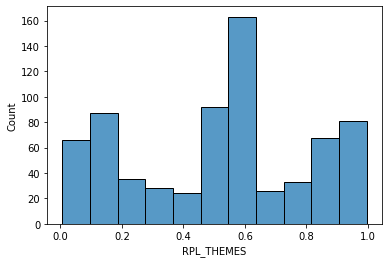

In [162]:
print("Variance of SVI scores of sample: {}".format(np.nanvar(df_sample['RPL_THEMES'].values)))
print("Variance of SVI scores of Texas: {}".format(np.nanvar(df_svi_tx['RPL_THEMES'].values)))
print("Average variance of SVI scores: {}".format(np.nanmean(ls_var)))
print("Max SVI score: {}".format(df_sample['RPL_THEMES'].max()))
print("Min SVI score: {}".format(df_sample['RPL_THEMES'].min()))

sns.histplot(data=df_sample['RPL_THEMES'])

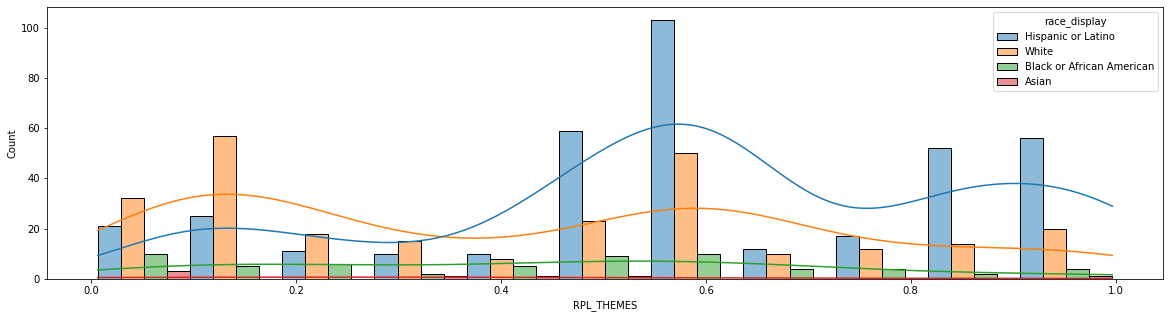

In [163]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(
    data=df_sample,
    x="RPL_THEMES",
    hue="race_display",
    multiple="dodge",
    kde=True
)

In [164]:
import matplotlib.colors as mcolors
cmap = sns.color_palette("flare", as_cmap=True)
len(cmap.colors)


256

In [165]:
ls_color = []
for idx, val in enumerate(cmap.colors):
    if idx in np.arange(start=0, stop=256, step=13):
        ls_color.append(val)



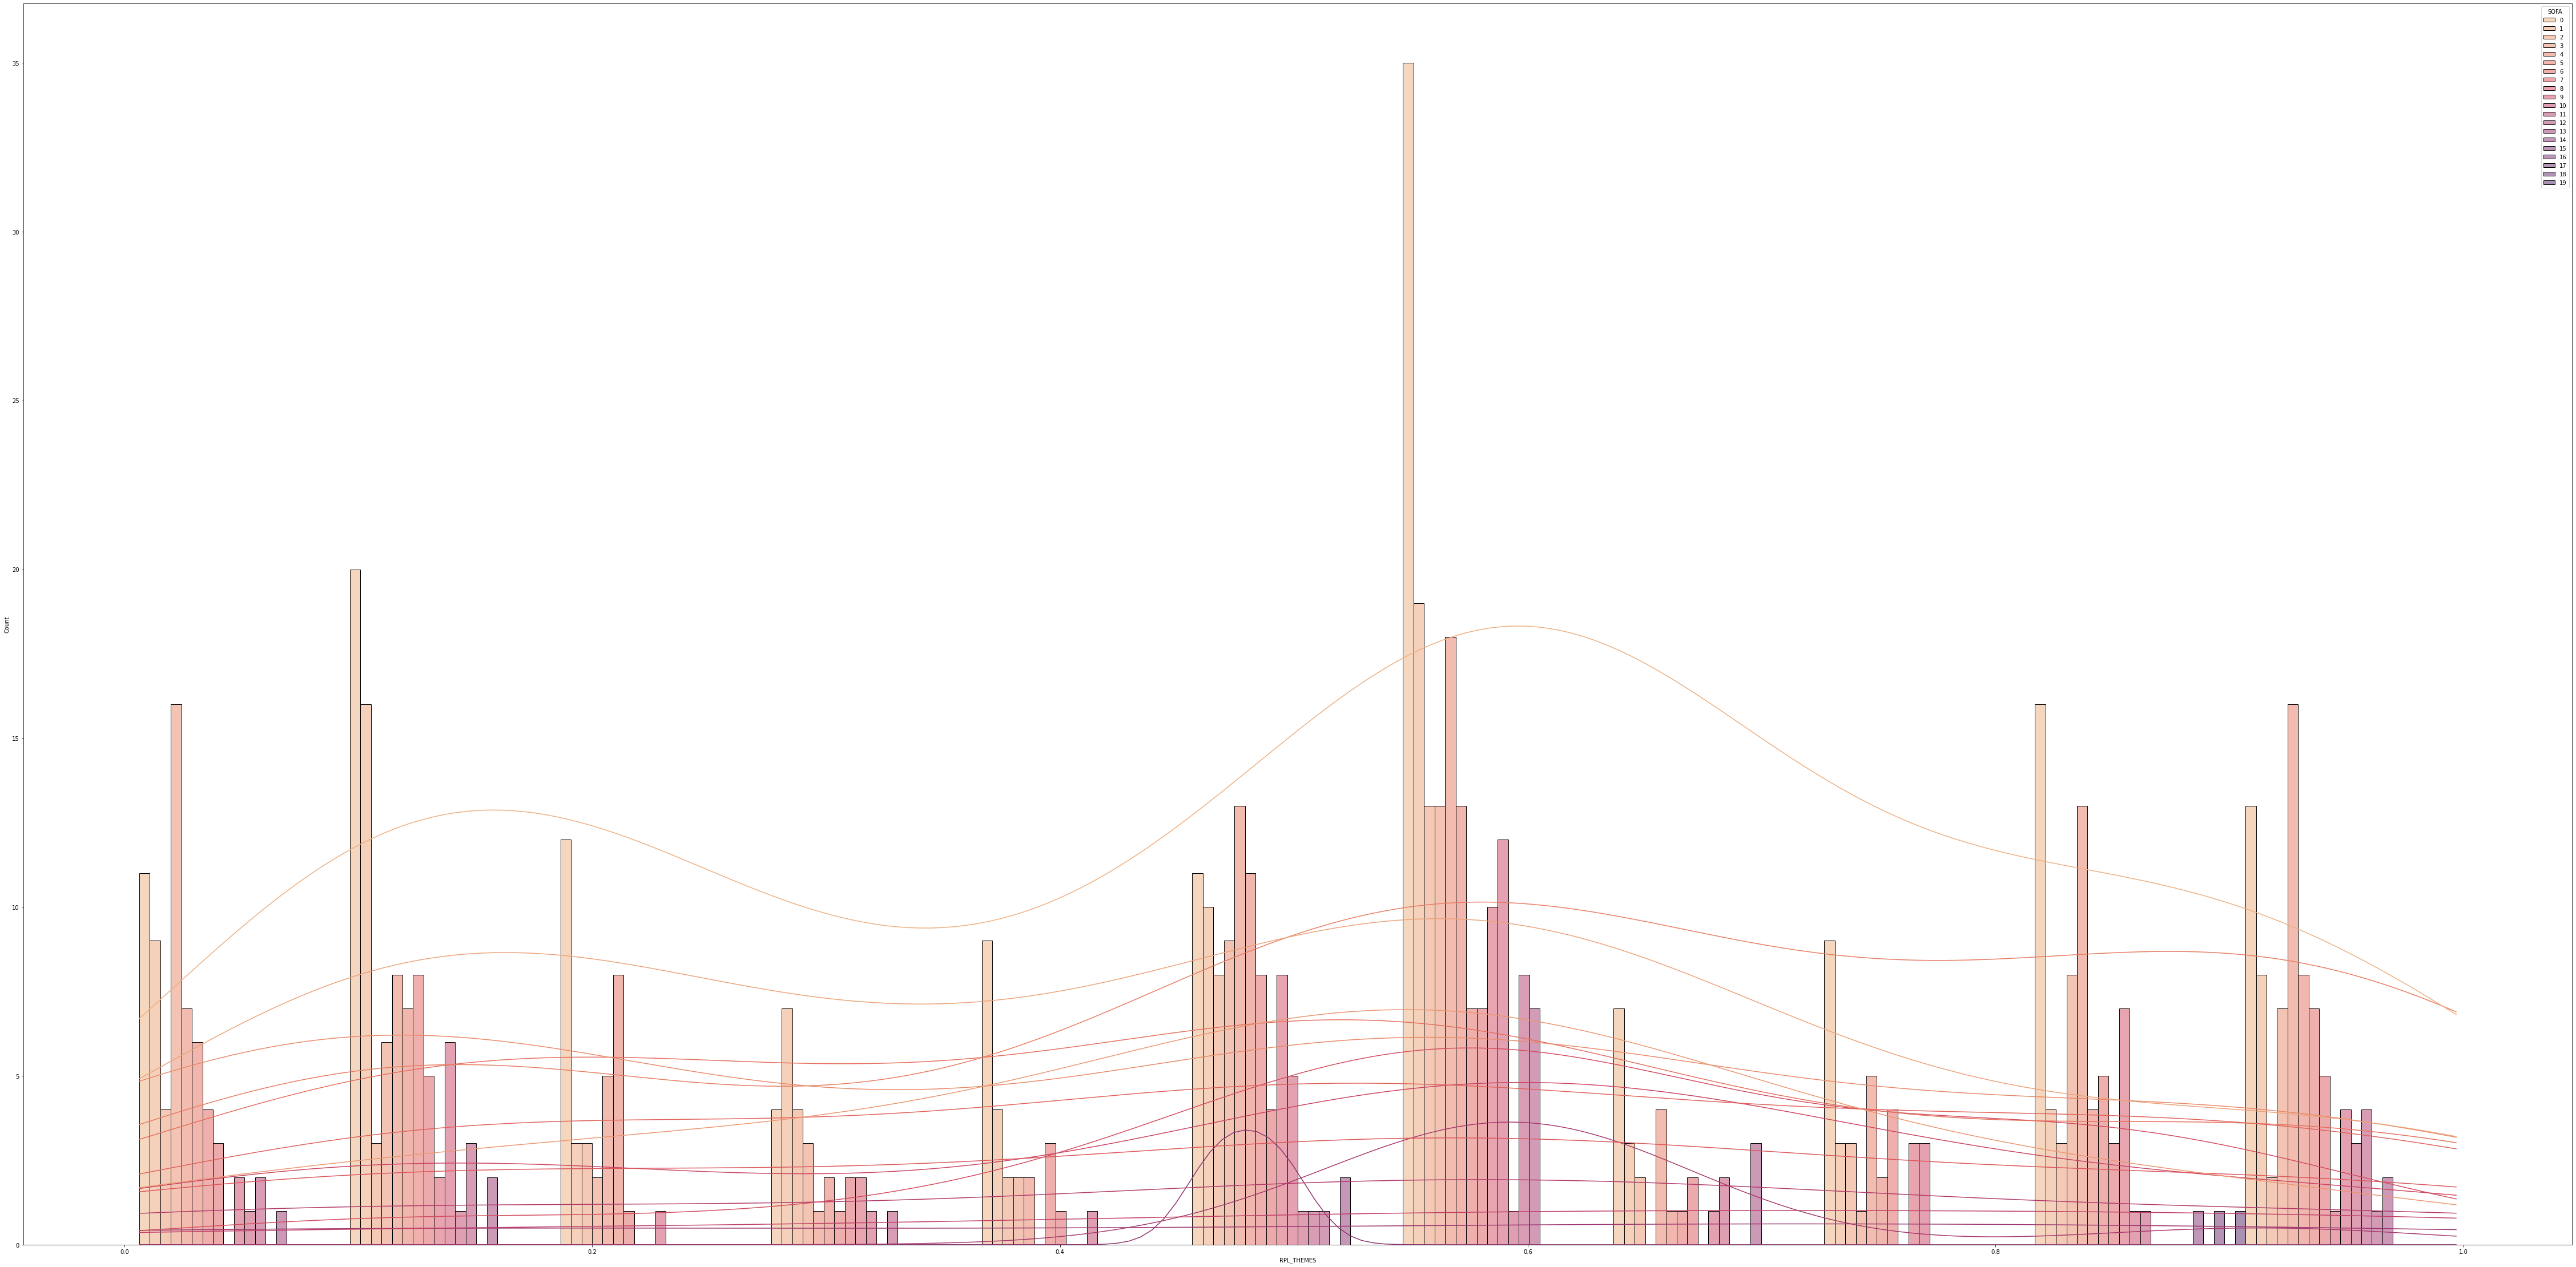

In [166]:
tmp = df_sample.copy()
tmp["SOFA"] = tmp["SOFA"].astype(str)
fig, ax = plt.subplots(figsize=(80,40))
sns.histplot(
    data=tmp,
    x="RPL_THEMES",
    hue="SOFA",
    hue_order=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
    multiple="dodge",
    kde=True,
    palette=ls_color
)

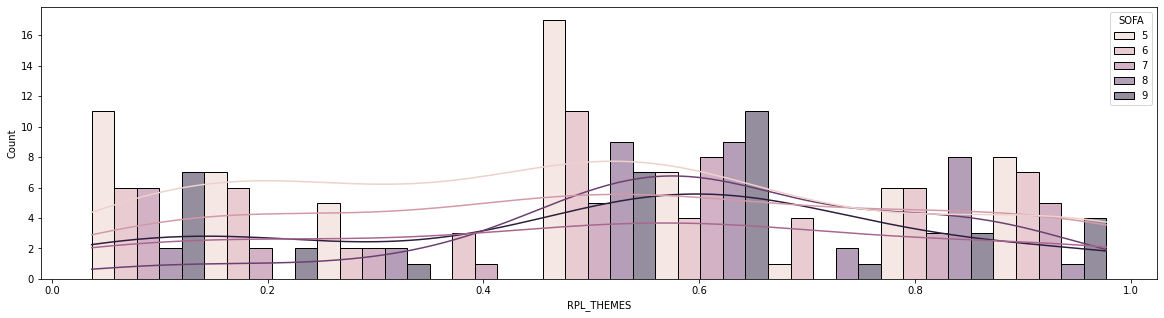

In [167]:
fig, ax = plt.subplots(figsize=(20,5))
sns.histplot(
    data=df_sample.loc[(df_sample["SOFA"] >= 5) & (df_sample["SOFA"] < 10)],
    x="RPL_THEMES",
    hue="SOFA",
    multiple="dodge",
    kde=True
)

# Visualization

In [ ]:
'''print('Average length of stay in encounter: {}'.format(round(df_sample["length_of_stay"].mean(), 2)))
print('Standard deviation length of stay in encounter: {}'.format(round(df_sample["length_of_stay"].std(), 2)))'''

'print(\'Average length of stay in encounter: {}\'.format(round(df_sample["length_of_stay"].mean(), 2)))\nprint(\'Standard deviation length of stay in encounter: {}\'.format(round(df_sample["length_of_stay"].std(), 2)))'

In [ ]:
print("Number of ICU patients: {}".format(df_sample.loc[df_sample['icu_hours_summed'].notnull()].shape[0]))
print("Number of ICU patients allocated to vents: {}".format(df_sample.loc[(df_sample['icu_hours_summed'].notnull()) & (df_sample["vent_hours_summed"].notnull())].shape[0]))

Number of ICU patients: 703
Number of ICU patients allocated to vents: 296


In [ ]:
df_sample.groupby(["race_display"]).agg({"deid_fin_encounter": "count"})

,deid_fin_encounter
race_display,
Asian,7
Black or African American,61
Hispanic or Latino,376
White,259


In [185]:
df_sample['race_display'].value_counts()

Hispanic or Latino           376
White                        259
Black or African American     61
Asian                          7
Name: race_display, dtype: int64

In [184]:
round(7/(7+61+376+259),2)

0.01

In [ ]:
df_sample.loc[(df_sample['icu_hours_summed'].notnull()) & (df_sample["vent_hours_summed"].notnull()), ['race_display']].value_counts() 

race_display             
Hispanic or Latino           171
White                         96
Black or African American     26
Asian                          3
dtype: int64

In [ ]:
df.loc[(df['icu_hours_summed'].notnull()) & (df["vent_hours_summed"].notnull()), ['race_display', 'ethnicity_display']].apply(lambda patient: latinx(patient), axis=1).value_counts()

Hispanic or Latino               156
White                             85
Black or African American         25
Other Race                        12
Unknown                            8
Decline to Specify                 4
Asian                              3
American Indian/Alaska Native      2
dtype: int64

### Distribution: Zip codes

In [ ]:
df_sample["ZCTA5"].nunique()

110

In [ ]:
cnt_group_zip = df_sample.groupby(["ZCTA5"]).agg({"deid_fin_encounter": "count"})
cnt_group_zip.loc[cnt_group_zip["deid_fin_encounter"]>1]

,deid_fin_encounter
ZCTA5,
76574,6
78130,4
78602,8
78605,3
78610,17
...,...
78942,2
78957,5
78959,3


In [ ]:
cnt_group_zip.loc[cnt_group_zip["deid_fin_encounter"]<=1].shape

(39, 1)

## Distribution: SOFA scores

In [ ]:
cnt_group_sofa = df_sample.groupby(by=["SOFA"]).agg({"deid_fin_encounter": "count"})
cnt_group_sofa

,deid_fin_encounter
SOFA,
0,147
1,86
2,47
3,67
4,92
5,62
6,49
7,32
8,33


In [ ]:
round(cnt_group_sofa[["deid_fin_encounter"]] / cnt_group_sofa["deid_fin_encounter"].sum() * 100, 2)

,deid_fin_encounter
SOFA,
0,20.91
1,12.23
2,6.69
3,9.53
4,13.09
5,8.82
6,6.97
7,4.55
8,4.69


In [ ]:
cnt_group_sofa = df_sample.groupby(by=["SOFA", 'race_display']).agg({"deid_fin_encounter": "count"}).reset_index()

In [ ]:
# White
display(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='White'])
round(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='White']['deid_fin_encounter']/np.sum(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='White', 'deid_fin_encounter']),2)

,SOFA,race_display,deid_fin_encounter
2,0,White,65
6,1,White,37
10,2,White,18
13,3,White,23
17,4,White,34
20,5,White,24
24,6,White,12
28,7,White,11
31,8,White,8
34,9,White,14


2     0.25
6     0.14
10    0.07
13    0.09
17    0.13
20    0.09
24    0.05
28    0.04
31    0.03
34    0.05
38    0.01
41    0.01
45    0.02
47    0.00
48    0.00
49    0.00
50    0.00
Name: deid_fin_encounter, dtype: float64

In [ ]:
0.25+0.14+0.07+0.09+0.13+0.09+0.05+0.04+0.03+0.05+0.01+0.01+0.02

0.9800000000000002

In [ ]:
print('Average SOFA score: {}'.format(df_sample.loc[df_sample['race_display']=='White', 'SOFA'].mean()))
print('Standard Deviation: {}'.format(df_sample.loc[df_sample['race_display']=='White', 'SOFA'].std()))

Average SOFA score: 3.501930501930502
Standard Deviation: 3.527713664766123


In [ ]:
print('Average SOFA score: {}'.format(df_sample.loc[df_sample['race_display']=='Hispanic or Latino', 'SOFA'].mean()))
print('Standard Deviation: {}'.format(df_sample.loc[df_sample['race_display']=='Hispanic or Latino', 'SOFA'].std()))

Average SOFA score: 4.159574468085107
Standard Deviation: 3.460414438344978


In [ ]:
print('Average SOFA score: {}'.format(df_sample.loc[df_sample['race_display']=='Black or African American', 'SOFA'].mean()))
print('Standard Deviation: {}'.format(df_sample.loc[df_sample['race_display']=='Black or African American', 'SOFA'].std()))

Average SOFA score: 4.459016393442623
Standard Deviation: 3.5757226332206997


In [ ]:
print('Average SOFA score: {}'.format(df_sample.loc[df_sample['race_display']=='Asian', 'SOFA'].mean()))
print('Standard Deviation: {}'.format(df_sample.loc[df_sample['race_display']=='Asian', 'SOFA'].std()))

Average SOFA score: 4.571428571428571
Standard Deviation: 3.25868802112869


In [ ]:
num_pat_total = df_sample.loc[df_sample['race_display']=='White'].shape[0]
num_pat_sofa = df_sample.loc[(df_sample['race_display']=='White') & (df_sample['SOFA']>=2)].shape[0]
#std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Number of White patients who have two or more comorbidities: {}.".format(round(num_pat_comorbidity/num_pat_total*100, 2)))

In [ ]:
# Hispanic or Latino
display(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Hispanic or Latino'])
round(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Hispanic or Latino']['deid_fin_encounter']/np.sum(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Hispanic or Latino', 'deid_fin_encounter']),2)

,SOFA,race_display,deid_fin_encounter
1,0,Hispanic or Latino,75
5,1,Hispanic or Latino,39
9,2,Hispanic or Latino,20
12,3,Hispanic or Latino,39
16,4,Hispanic or Latino,53
19,5,Hispanic or Latino,32
23,6,Hispanic or Latino,27
27,7,Hispanic or Latino,17
30,8,Hispanic or Latino,21
33,9,Hispanic or Latino,21


1     0.20
5     0.10
9     0.05
12    0.10
16    0.14
19    0.09
23    0.07
27    0.05
30    0.06
33    0.06
37    0.02
40    0.04
42    0.02
44    0.01
Name: deid_fin_encounter, dtype: float64

In [ ]:
# Black or African American
display(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Black or African American'])
round(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Black or African American']['deid_fin_encounter']/np.sum(cnt_group_sofa.loc[cnt_group_sofa['race_display']=='Black or African American', 'deid_fin_encounter']),2)

,SOFA,race_display,deid_fin_encounter
0,0,Black or African American,7
4,1,Black or African American,9
8,2,Black or African American,7
11,3,Black or African American,5
15,4,Black or African American,4
18,5,Black or African American,6
22,6,Black or African American,9
26,7,Black or African American,3
29,8,Black or African American,4
32,9,Black or African American,1


0     0.11
4     0.15
8     0.11
11    0.08
15    0.07
18    0.10
22    0.15
26    0.05
29    0.07
32    0.02
36    0.02
39    0.03
43    0.03
46    0.02
Name: deid_fin_encounter, dtype: float64

# Social Vulnerable Index

In [ ]:
df_sample['cat_SVI'] = pd.Categorical(df_sample['cat_SVI'], ['High', 'Moderate', 'Low'])
df_sample['race_display'] = pd.Categorical(df_sample['race_display'], ['White', 'Hispanic or Latino', 'Black or African American', 'Asian'])

In [ ]:
df_sample.sort_values(['cat_SVI', 'race_display'], ascending=True).groupby(['cat_SVI', 'race_display']).agg({'deid_fin_encounter': 'count'})

deid_fin_encounter
cat_SVI  race_display                                 
High     White                                      51
         Hispanic or Latino                        127
         Black or African American                  12
         Asian                                       1
Moderate White                                      94
         Hispanic or Latino                        183
         Black or African American                  26
         Asian                                       3
Low      White                                     114
         Hispanic or Latino                         66
         Black or African American                  23
         Asian                                       3

In [ ]:
pct = df_sample.sort_values(['cat_SVI'], ascending=True).groupby(['cat_SVI']).agg({'deid_fin_encounter': 'count'}).reset_index()
pct['pct'] = pct['deid_fin_encounter'].apply(lambda x: round(100 * x / pct['deid_fin_encounter'].sum(), 0))
pct

,cat_SVI,deid_fin_encounter,pct
0,High,191,27.0
1,Moderate,306,44.0
2,Low,206,29.0


In [ ]:
pct = df_sample.sort_values(['race_display'], ascending=True).groupby(['race_display']).agg({'deid_fin_encounter': 'count'}).reset_index()
pct['pct'] = pct['deid_fin_encounter'].apply(lambda x: round(100 * x / pct['deid_fin_encounter'].sum(), 0))
pct

,race_display,deid_fin_encounter,pct
0,White,259,37.0
1,Hispanic or Latino,376,53.0
2,Black or African American,61,9.0
3,Asian,7,1.0


## Distribution: Race

In [ ]:
df_sample.sort_values(['cat_SVI', 'race_display'], ascending=True).groupby(['cat_SVI', 'race_display']).agg({'deid_fin_encounter': 'count'})

deid_fin_encounter
cat_SVI  race_display                                 
High     White                                      51
         Hispanic or Latino                        127
         Black or African American                  12
         Asian                                       1
Moderate White                                      94
         Hispanic or Latino                        183
         Black or African American                  26
         Asian                                       3
Low      White                                     114
         Hispanic or Latino                         66
         Black or African American                  23
         Asian                                       3

In [ ]:
pct = df_sample.sort_values(['cat_SVI', 'race_display'], ascending=True).groupby(['cat_SVI', 'race_display']).agg({'deid_fin_encounter': 'count'}).reset_index()

In [ ]:
pct.loc[pct['cat_SVI']=='High', 'deid_fin_encounter']

0     51
1    127
2     12
3      1
Name: deid_fin_encounter, dtype: int64

In [ ]:
pct = df_sample.sort_values(['cat_SVI', 'race_display'], ascending=True).groupby(['cat_SVI', 'race_display']).agg({'deid_fin_encounter': 'count'}).reset_index()
pct.loc[pct['cat_SVI']=='High', 'deid_fin_encounter'].sum()

191

In [ ]:
for i, row in pct.iterrows():
    #print(row)
    print(row['deid_fin_encounter']/pct.loc[pct['cat_SVI']==row['cat_SVI'], 'deid_fin_encounter'].sum())

0.2670157068062827
0.6649214659685864
0.06282722513089005
0.005235602094240838
0.30718954248366015
0.5980392156862745
0.08496732026143791
0.00980392156862745
0.5533980582524272
0.32038834951456313
0.11165048543689321
0.014563106796116505


In [ ]:
pct = df_sample.sort_values(['cat_SVI', 'race_display'], ascending=True).groupby(['cat_SVI', 'race_display']).agg({'deid_fin_encounter': 'count'}).reset_index()
#pct['pct'] = pct['deid_fin_encounter'].apply(lambda x: round(100 * x / pct['deid_fin_encounter'].sum(), 0))
#pct['pct'] = pct.apply(lambda x: round(100 * x.deid_fin_encounter / pct.loc[pct['cat_SVI']==x.cat_SVI, 'deid_fin_encounter'].sum(), 0))
tmp_ls = []
for i, row in pct.iterrows():
    tmp_ls.append(round(100*row['deid_fin_encounter']/pct.loc[pct['cat_SVI']==row['cat_SVI'], 'deid_fin_encounter'].sum(), 1))
    #pct
    #pct['pct'].iloc[i] = round(100*row['deid_fin_encounter']/pct.loc[pct['cat_SVI']==row['cat_SVI'], 'deid_fin_encounter'].sum(), 2)
    #print(pct.iloc[i])
    #print(round(100*row['deid_fin_encounter']/pct.loc[pct['cat_SVI']==row['cat_SVI'], 'deid_fin_encounter'].sum(), 2))

pct['pct'] = tmp_ls
pct

,cat_SVI,race_display,deid_fin_encounter,pct
0,High,White,51,26.7
1,High,Hispanic or Latino,127,66.5
2,High,Black or African American,12,6.3
3,High,Asian,1,0.5
4,Moderate,White,94,30.7
5,Moderate,Hispanic or Latino,183,59.8
6,Moderate,Black or African American,26,8.5
7,Moderate,Asian,3,1.0
8,Low,White,114,55.3
9,Low,Hispanic or Latino,66,32.0


### White

In [ ]:
df_sample.loc[df_sample['race_display']=='White', ['SOFA']].describe().round(2)

,SOFA
count,259.00
mean,3.50
std,3.53
min,0.00
25%,0.50
50%,3.00
75%,5.00
max,19.00


In [ ]:
df_sample.loc[df_sample['race_display']=='White', ['SOFA']].median()

SOFA    3.0
dtype: float64

Text(0.5, 0, 'SOFA')

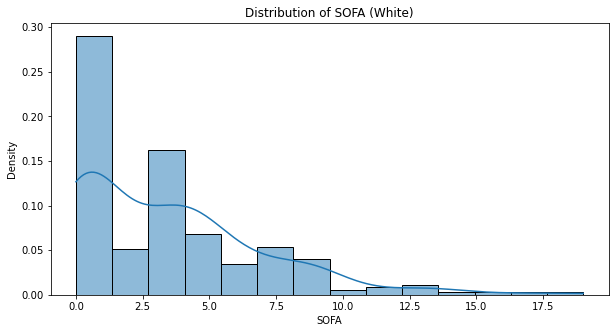

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='White'],
    x="SOFA",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of SOFA (White)')
plt.xlabel('SOFA')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

### Hispanic or Latino

In [ ]:
df_sample.loc[df_sample['race_display']=='Hispanic or Latino', ['SOFA']].describe().round(2)

,SOFA
count,376.00
mean,4.16
std,3.46
min,0.00
25%,1.00
50%,4.00
75%,6.00
max,13.00


In [ ]:
df_sample.loc[df_sample['race_display']=='Hispanic or Latino', ['SOFA']].median()

SOFA    4.0
dtype: float64

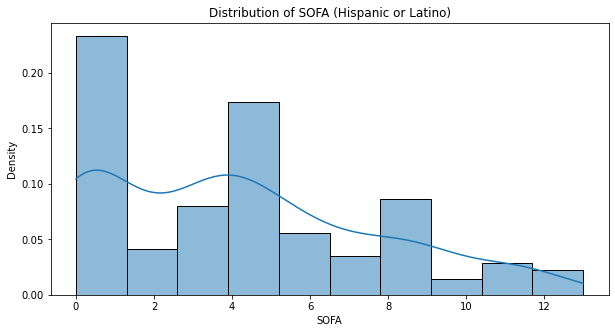

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Hispanic or Latino'],
    x="SOFA",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of SOFA (Hispanic or Latino)')
plt.xlabel('SOFA')
plt.savefig("figures_new/dist_sofa({}).png".format('Hispanic or Latino'))

### Black or African American

In [ ]:
df_sample.loc[df_sample['race_display']=='Black or African American', ['SOFA']].describe().round(2)

,SOFA
count,61.00
mean,4.46
std,3.58
min,0.00
25%,1.00
50%,4.00
75%,6.00
max,14.00


In [ ]:
df_sample.loc[df_sample['race_display']=='Black or African American', ['SOFA']].median()

SOFA    4.0
dtype: float64

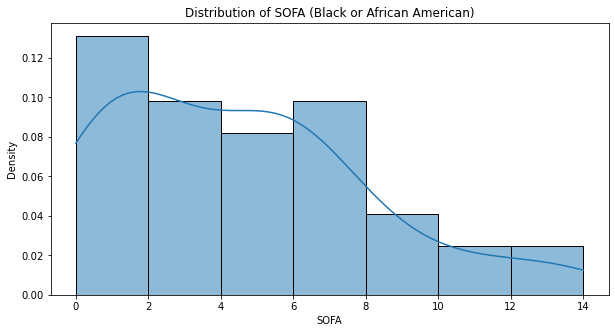

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Black or African American'],
    x="SOFA",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of SOFA (Black or African American)')
plt.xlabel('SOFA')
plt.savefig("figures_new/dist_sofa({}).png".format('Black or African American'))

### Asian

In [ ]:
df_sample.loc[df_sample['race_display']=='Asian', ['SOFA']].describe().round(2)

,SOFA
count,7.00
mean,4.57
std,3.26
min,1.00
25%,2.00
50%,4.00
75%,6.50
max,10.00


In [ ]:
df_sample.loc[df_sample['race_display']=='Asian', ['SOFA']].median()

SOFA    4.0
dtype: float64

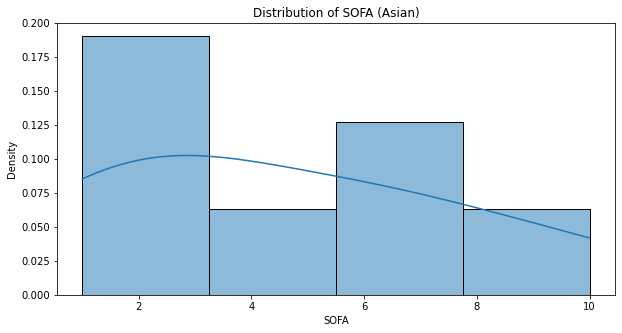

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="SOFA",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of SOFA (Asian)')
plt.xlabel('SOFA')
plt.savefig("figures_new/dist_sofa({}).png".format('Asian'))

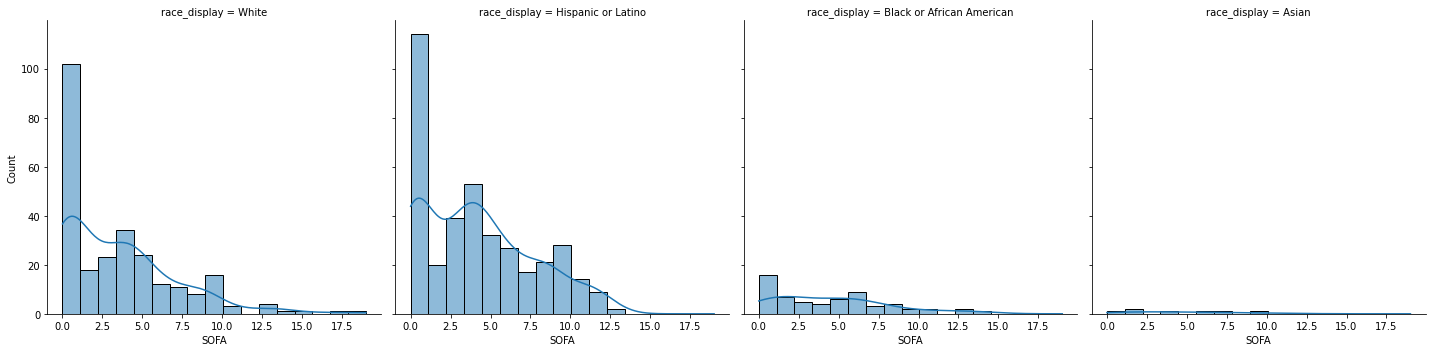

In [ ]:
sns.displot(df_sample, x="SOFA", col="race_display", multiple="dodge", kde=True)

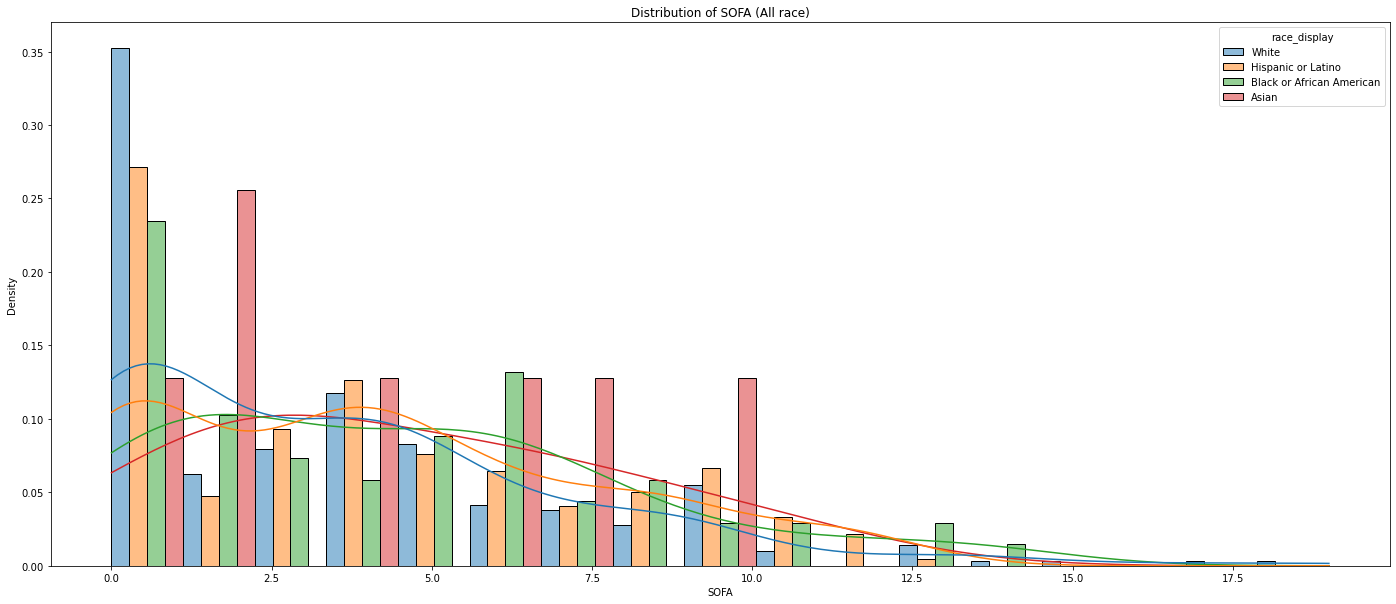

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="SOFA",
    hue="race_display",
    stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of SOFA (All race)')
plt.xlabel('SOFA')
plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'Race')

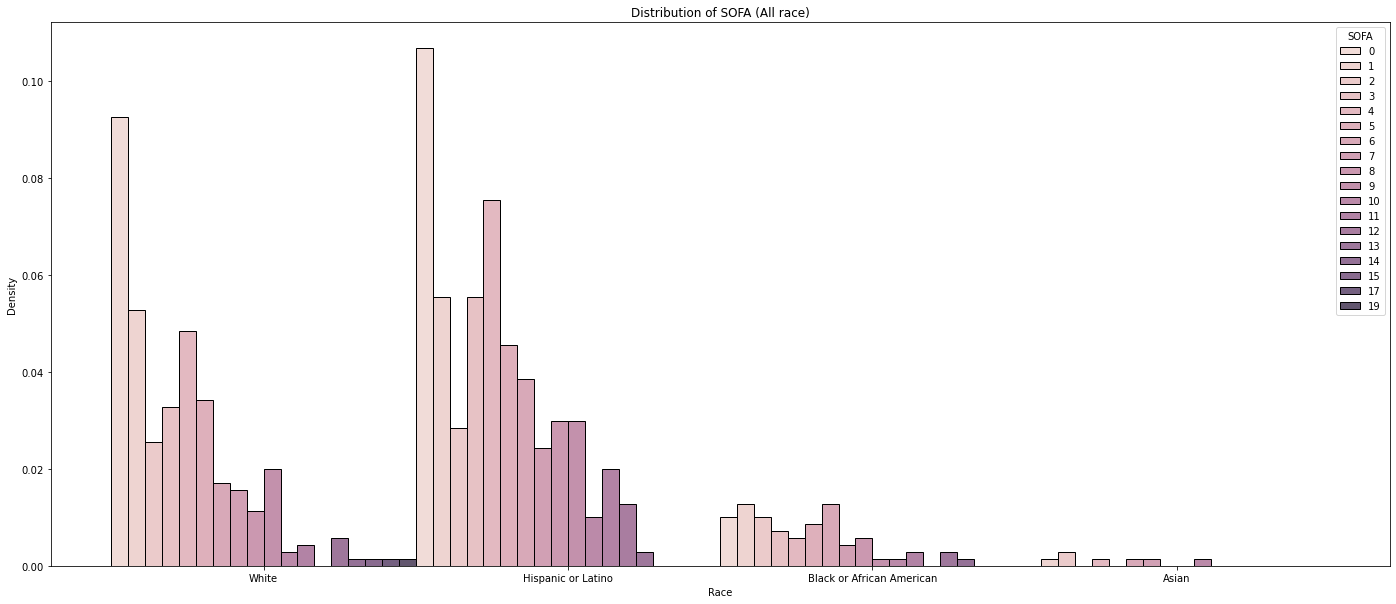

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    data=df_sample,
    x='race_display',
    hue='SOFA',
    stat="density",
    multiple="dodge"
)
plt.title('Distribution of SOFA (All race)')
plt.xlabel('Race')

In [ ]:
df_sample_pct = df_sample.groupby(['SOFA']).agg({'deid_fin_encounter': 'count'}).copy()
df_sample_pct['percentage'] = df_sample_pct.loc[:, ['deid_fin_encounter']].apply(lambda x: round(x/x.sum(), 2))
df_sample_pct

,deid_fin_encounter,percentage
SOFA,,
0,147,0.21
1,86,0.12
2,47,0.07
3,67,0.10
4,92,0.13
5,62,0.09
6,49,0.07
7,32,0.05
8,33,0.05


In [ ]:
df_sample.loc[df_sample['race_display']=='Asian']

,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI
1154,25299,34,Male,Asian,Insured,199.00,NaN,7,1,2,66,Home,NaN,78741,2411,48453002411,7453,1986,26.7,241,6.9,15378,1493,37.4,0.8776,0.7650,0.9061,0.9908,0.9773,0,1,1,1,3,High
3273,43847,57,Male,Asian,Insured,373.32,280.60,6,1,1,43,Expired,5/22/2020 2:42,78653,2207,48453002207,9453,986,10.4,99,1.9,23059,1390,23.6,0.4178,0.4273,0.7928,0.3108,0.4674,0,0,0,0,0,Moderate
4472,33717,32,Male,Asian,Insured,152.43,NaN,2,1,1,68,Skilled Nursing Care,NaN,78665,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low
5776,46873,69,Female,Asian,Insured,629.97,617.02,10,1,1,31,Expired,7/29/2020 11:55,78664,20804,48491020804,11472,314,2.7,390,6.2,49695,80,1.1,0.1460,0.1693,0.2259,0.0810,0.0791,0,0,0,0,0,Low
6012,27252,53,Female,Asian,Insured,17.65,NaN,2,1,2,47,Home,NaN,78728,1851,48453001851,10003,1370,13.8,308,5.5,34846,156,2.3,0.3047,0.2331,0.6155,0.7322,0.4551,0,0,0,1,1,Moderate
6116,42195,41,Male,Asian,Insured,3.87,0.67,1,1,2,59,Home,NaN,78645,1766,48453001766,9336,704,7.5,388,8.2,44431,756,11.2,0.3671,0.1551,0.2555,0.6804,0.3489,0,0,0,0,0,Moderate
6538,41187,69,Female,Asian,Insured,24.97,NaN,4,1,4,31,Expired,8/6/2020 3:15,78731,1716,48453001716,6816,175,2.6,165,3.8,74717,18,0.3,0.0393,0.0816,0.1234,0.1847,0.0503,0,0,0,0,0,Low


In [ ]:
count_race = Counter(df_sample['race_display'])
count_race

Counter({'Hispanic or Latino': 376,
         'White': 259,
         'Black or African American': 61,
         'Asian': 7})

In [ ]:
df_left = df_sample.groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_patients'})
df_right = df_sample.loc[df_sample['discharge_disposition_display']=='Expired'].groupby(['SOFA'])[['deid_fin_encounter']].agg('count').reset_index(level=['SOFA'], col_level=1).rename(columns={'deid_fin_encounter': 'num_death'})

In [ ]:
df_center = df_left.merge(df_right, on='SOFA', how='left')
#df_center['num_patients']/df_center['num_death']
df_center['percentage_death'] = round(df_center['num_death']/df_center['num_patients']*100, 0)
df_center

,SOFA,num_patients,num_death,percentage_death
0,0,147,3.0,2.0
1,1,86,4.0,5.0
2,2,47,4.0,9.0
3,3,67,16.0,24.0
4,4,92,22.0,24.0
5,5,62,20.0,32.0
6,6,49,21.0,43.0
7,7,32,9.0,28.0
8,8,33,15.0,45.0
9,9,36,20.0,56.0


## Distribution: Vent allocation

In [ ]:
print('Number of patients who are in ICU: {}'.format(len(df.loc[df['icu_hours_summed'].notnull()])))
print('Number of patients who are NOT in ICU: {}'.format(len(df.loc[df['icu_hours_summed'].isnull()])))
print('-------------------------------------------------------------------------------------')

# ICU & Vent allocated
df_icu_vent_allocated = df.loc[(df['icu_hours_summed'].notnull() & (df['vent_hours_summed'].notnull()))]
print('Number of patients who are in ICU and allocated to vents: {}'.format(len(df_icu_vent_allocated)))
print('Percentage of patients who are in ICU and allocated to vents: {}%'.format(round(len(df_icu_vent_allocated)/len(df.loc[df['icu_hours_summed'].notnull()]), 2)))
print('\n')
df_icu_vent_allocated_die = df.loc[(df['icu_hours_summed'].notnull() & (df['vent_hours_summed'].notnull()) & (df['discharge_disposition_display']=='Expired'))]
print('Number of patients who are in ICU, allocated to vents, and DIE: {}'.format(len(df_icu_vent_allocated_die)))
print('Percentage of patients who are in ICU, allocated to vents, and DIE: {}%'.format(round(len(df_icu_vent_allocated_die)/len(df_icu_vent_allocated), 2)))
print('\n')
df_icu_vent_allocated_survive = df.loc[(df['icu_hours_summed'].notnull() & (df['vent_hours_summed'].notnull()) & (df['discharge_disposition_display']!='Expired'))]
print('Number of patients who are in ICU, allocated to vents, and SURVIVE: {}'.format(len(df_icu_vent_allocated_survive)))
print('Percentage of patients who are in ICU, allocated to vents, and SURVIVE: {}%'.format(round(len(df_icu_vent_allocated_survive)/len(df_icu_vent_allocated), 2)))

print('-------------------------------------------------------------------------------------')


# ICU & Vent NOT allocated
df_icu_vent_allocated_not = df.loc[(df['icu_hours_summed'].notnull()) & (df['vent_hours_summed'].isnull())]
print('Number of patients who are in ICU and NOT allocated to vents: {}'.format(len(df_icu_vent_allocated_not)))
print('Percentage of patients who are in ICU and NOT allocated to vents: {}%'.format(round(len(df_icu_vent_allocated_not)/len(df.loc[df['icu_hours_summed'].notnull()]), 2)))
print('\n')
df_icu_vent_allocated_not_die = df.loc[(df['icu_hours_summed'].notnull()) & (df['vent_hours_summed'].isnull() & (df['discharge_disposition_display']=='Expired'))]
print('Number of patients who are in ICU, NOT allocated to vents, and DIE: {}'.format(len(df_icu_vent_allocated_not_die)))
print('Percentage of patients who are in ICU, NOT allocated to vents, and DIE: {}%'.format(round(len(df_icu_vent_allocated_not_die)/len(df_icu_vent_allocated_not), 2)))
print('\n')
df_icu_vent_allocated_not_survive = df.loc[(df['icu_hours_summed'].notnull()) & (df['vent_hours_summed'].isnull() & (df['discharge_disposition_display']!='Expired'))]
print('Number of patients who are in ICU, NOT allocated to vents, and SURVIVE: {}'.format(len(df_icu_vent_allocated_not_survive)))
print('Percentage of patients who are in ICU, NOT allocated to vents, and SURVIVE: {}%'.format(round(len(df_icu_vent_allocated_not_survive)/len(df_icu_vent_allocated_not), 2)))

print('-------------------------------------------------------------------------------------')

# NOT ICU & Vent allocated
df_icu_not_vent_allocated = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].notnull()))]
print('Number of patients who are NOT in ICU and allocated to vents: {}'.format(len(df_icu_not_vent_allocated)))
print('Percentage of patients who are NOT in ICU and allocated to vents: {}%'.format(round(len(df_icu_not_vent_allocated)/len(df.loc[df['icu_hours_summed'].isnull()]), 2)))
print('\n')
df_icu_not_vent_allocated_die = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].notnull()) & (df['discharge_disposition_display']=='Expired'))]
print('Number of patients who are NOT in ICU, allocated to vents, and DIE: {}'.format(len(df_icu_not_vent_allocated_die)))
print('Percentage of patients who are NOT in ICU, allocated to vents, and DIE: {}%'.format(round(len(df_icu_not_vent_allocated_die)/len(df_icu_not_vent_allocated), 2)))
print('\n')
df_icu_not_vent_allocated_survive = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].notnull()) & (df['discharge_disposition_display']!='Expired'))]
print('Number of patients who are NOT in ICU, allocated to vents, and SURVIVE: {}'.format(len(df_icu_not_vent_allocated_survive)))
print('Percentage of patients who are NOT in ICU, allocated to vents, and SURVIVE: {}%'.format(round(len(df_icu_not_vent_allocated_survive)/len(df_icu_not_vent_allocated), 2)))

print('-------------------------------------------------------------------------------------')

# NOT ICU & Vent NOT allocated
df_icu_not_vent_allocated_not = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].isnull()))]
print('Number of patients who are NOT in ICU and NOT allocated to vents: {}'.format(len(df_icu_not_vent_allocated_not)))
print('Percentage of patients who are NOT in ICU and NOT allocated to vents: {}%'.format(round(len(df_icu_not_vent_allocated_not)/len(df.loc[df['icu_hours_summed'].isnull()]), 2)))
print('\n')
df_icu_not_vent_allocated_not_die = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].isnull()) & (df['discharge_disposition_display']=='Expired'))]
print('Number of patients who are NOT in ICU, NOT allocated to vents, and DIE: {}'.format(len(df_icu_not_vent_allocated_not_die)))
print('Percentage of patients who are NOT in ICU, NOT allocated to vents, and DIE: {}%'.format(round(len(df_icu_not_vent_allocated_not_die)/len(df_icu_not_vent_allocated_not), 2)))
print('\n')
df_icu_not_vent_allocated_not_survive = df.loc[(df['icu_hours_summed'].isnull() & (df['vent_hours_summed'].isnull()) & (df['discharge_disposition_display']!='Expired'))]
print('Number of patients who are NOT in ICU, NOT allocated to vents, and SURVIVE: {}'.format(len(df_icu_not_vent_allocated_not_survive)))
print('Percentage of patients who are NOT in ICU, NOT allocated to vents, and SURVIVE: {}%'.format(round(len(df_icu_not_vent_allocated_not_survive)/len(df_icu_not_vent_allocated_not), 2)))

Number of patients who are in ICU: 741
Number of patients who are NOT in ICU: 1728
-------------------------------------------------------------------------------------
Number of patients who are in ICU and allocated to vents: 295
Percentage of patients who are in ICU and allocated to vents: 0.4%


Number of patients who are in ICU, allocated to vents, and DIE: 117
Percentage of patients who are in ICU, allocated to vents, and DIE: 0.4%


Number of patients who are in ICU, allocated to vents, and SURVIVE: 178
Percentage of patients who are in ICU, allocated to vents, and SURVIVE: 0.6%
-------------------------------------------------------------------------------------
Number of patients who are in ICU and NOT allocated to vents: 446
Percentage of patients who are in ICU and NOT allocated to vents: 0.6%


Number of patients who are in ICU, NOT allocated to vents, and DIE: 47
Percentage of patients who are in ICU, NOT allocated to vents, and DIE: 0.11%


Number of patients who are in IC

## Distribution: Age

### White

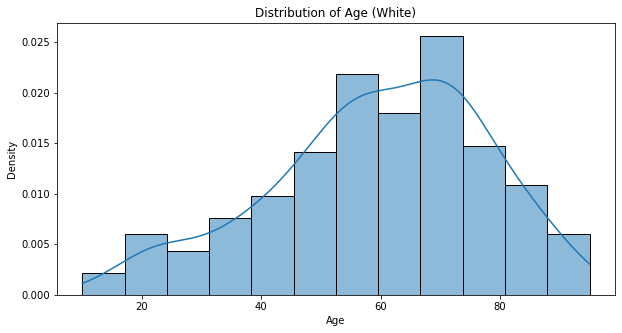

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='White'],
    x="age_at_admit",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Age (White)')
plt.xlabel('Age')
plt.savefig("figures_new/dist_age({}).png".format('White'))

In [ ]:
mean_age = df_sample.loc[df_sample['race_display']=='White', "age_at_admit"].mean()
std_age = df_sample.loc[df_sample['race_display']=='White', "age_at_admit"].std()

print("Mean age of White patients: {}.".format(round(mean_age, 2)))
print("Standard deviation age of White patients: {}.".format(round(std_age, 2)))

Mean age of White patients: 59.63.
Standard deviation age of White patients: 18.01.


### Hispanic or Latino

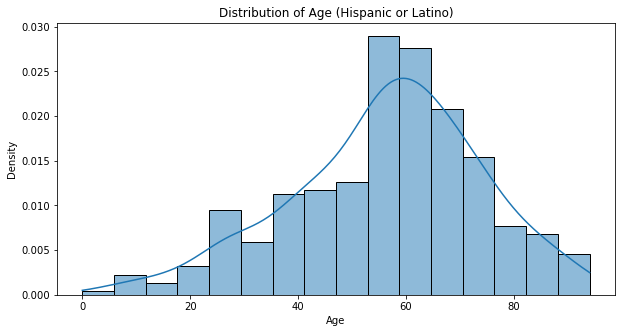

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Hispanic or Latino'],
    x="age_at_admit",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Age (Hispanic or Latino)')
plt.xlabel('Age')
plt.savefig("figures_new/dist_age({}).png".format('Hispanic or Latino'))

In [ ]:
mean_age = df_sample.loc[df_sample['race_display']=='Hispanic or Latino', "age_at_admit"].mean()
std_age = df_sample.loc[df_sample['race_display']=='Hispanic or Latino', "age_at_admit"].std()

print("Mean age of Hispanic or Latino patients: {}.".format(round(mean_age, 2)))
print("Standard deviation age of Hispanic or Latino patients: {}.".format(round(std_age, 2)))

Mean age of Hispanic or Latino patients: 56.28.
Standard deviation age of Hispanic or Latino patients: 17.81.


### Black or African American

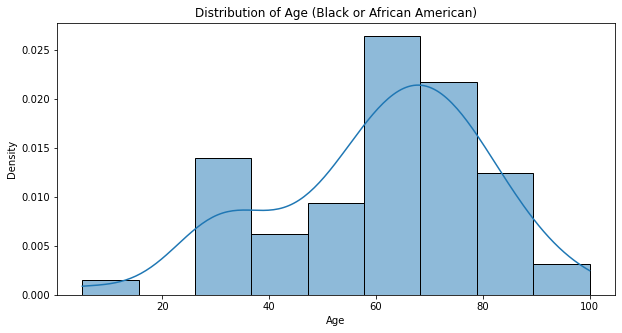

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Black or African American'],
    x="age_at_admit",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Age (Black or African American)')
plt.xlabel('Age')
plt.savefig("figures_new/dist_age({}).png".format('Black or African American'))

In [ ]:
mean_age = df_sample.loc[df_sample['race_display']=='Black or African American', "age_at_admit"].mean()
std_age = df_sample.loc[df_sample['race_display']=='Black or African American', "age_at_admit"].std()

print("Mean age of Black or African American patients: {}.".format(round(mean_age, 2)))
print("Standard deviation age of Black or African American patients: {}.".format(round(std_age, 2)))

Mean age of Black or African American patients: 60.8.
Standard deviation age of Black or African American patients: 19.4.


### Asian

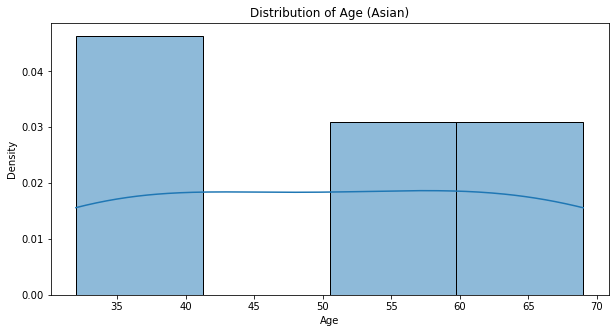

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="age_at_admit",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Age (Asian)')
plt.xlabel('Age')
plt.savefig("figures_new/dist_age({}).png".format('Asian'))

In [ ]:
mean_age = df_sample.loc[df_sample['race_display']=='Asian', "age_at_admit"].mean()
std_age = df_sample.loc[df_sample['race_display']=='Asian', "age_at_admit"].std()

print("Mean age of Asian patients: {}.".format(round(mean_age, 2)))
print("Standard deviation age of Asian patients: {}.".format(round(std_age, 2)))

Mean age of Asian patients: 50.71.
Standard deviation age of Asian patients: 15.48.


## Distribution: Comorbidity

### White

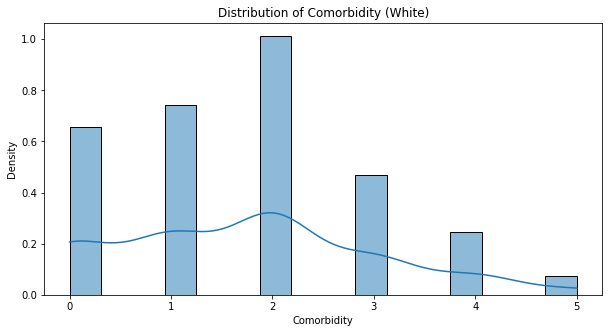

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='White'],
    x="count_comorbidity",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Comorbidity (White)')
plt.xlabel('Comorbidity')
plt.savefig("figures_new/dist_comorbidity({}).png".format('White'))

In [ ]:
mean_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].mean()
std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Mean comorbidity of White patients: {}.".format(round(mean_comorbidity, 2)))
print("Standard deviation comorbidity of White patients: {}.".format(round(std_comorbidity, 2)))

Mean comorbidity of White patients: 1.73.
Standard deviation comorbidity of White patients: 1.28.


In [ ]:
num_pat_total = df_sample.loc[df_sample['race_display']=='White'].shape[0]
num_pat_comorbidity = df_sample.loc[(df_sample['race_display']=='White') & (df_sample['count_comorbidity']>=2)].shape[0]
#std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Number of White patients who have two or more comorbidities: {}.".format(round(num_pat_comorbidity/num_pat_total*100, 2)))

Number of White patients who have two or more comorbidities: 56.37.


### Hispanic or Latino

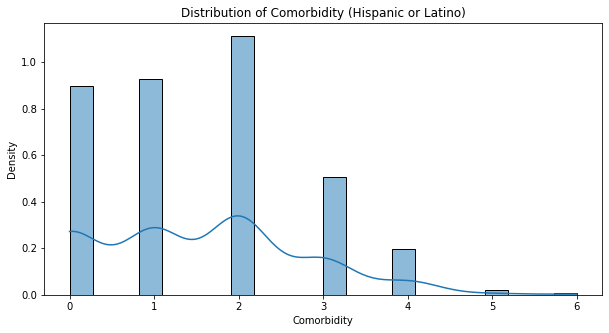

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Hispanic or Latino'],
    x="count_comorbidity",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Comorbidity (Hispanic or Latino)')
plt.xlabel('Comorbidity')
plt.savefig("figures_new/dist_comorbidity({}).png".format('Hispanic or Latino'))

In [ ]:
num_pat_total = df_sample.loc[df_sample['race_display']=='Hispanic or Latino'].shape[0]
num_pat_comorbidity = df_sample.loc[(df_sample['race_display']=='Hispanic or Latino') & (df_sample['count_comorbidity']>=2)].shape[0]
#std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Number of Hispanic or Latino patients who have two or more comorbidities: {}.".format(round(num_pat_comorbidity/num_pat_total*100, 2)))

Number of Hispanic or Latino patients who have two or more comorbidities: 50.27.


### Black or African American

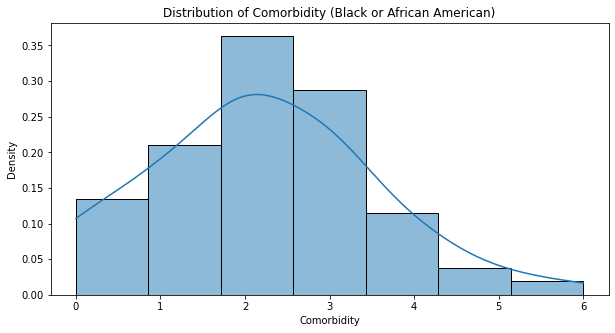

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Black or African American'],
    x="count_comorbidity",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Comorbidity (Black or African American)')
plt.xlabel('Comorbidity')
plt.savefig("figures_new/dist_comorbidity({}).png".format('Black or African American'))

In [ ]:
num_pat_total = df_sample.loc[df_sample['race_display']=='Black or African American'].shape[0]
num_pat_comorbidity = df_sample.loc[(df_sample['race_display']=='Black or African American') & (df_sample['count_comorbidity']>=2)].shape[0]
#std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Number of Black or African American patients who have two or more comorbidities: {}.".format(round(num_pat_comorbidity/num_pat_total*100, 2)))

Number of Black or African American patients who have two or more comorbidities: 70.49.


### Asian

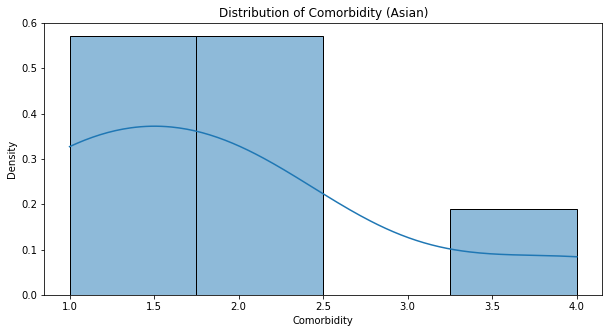

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="count_comorbidity",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Comorbidity (Asian)')
plt.xlabel('Comorbidity')
plt.savefig("figures_new/dist_comorbidity({}).png".format('Asian'))

In [ ]:
num_pat_total = df_sample.loc[df_sample['race_display']=='Asian'].shape[0]
num_pat_comorbidity = df_sample.loc[(df_sample['race_display']=='Asian') & (df_sample['count_comorbidity']>=2)].shape[0]
#std_comorbidity = df_sample.loc[df_sample['race_display']=='White', "count_comorbidity"].std()

print("Number of Asian patients who have two or more comorbidities: {}.".format(round(num_pat_comorbidity/num_pat_total*100, 2)))

Number of Asian patients who have two or more comorbidities: 57.14.


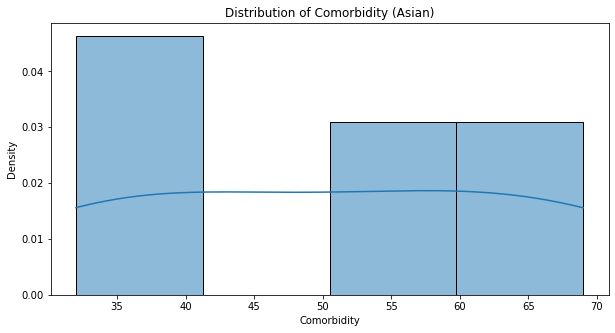

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="age_at_admit",
    stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Comorbidity (Asian)')
plt.xlabel('Comorbidity')
plt.savefig("figures_new/dist_comorbidity({}).png".format('Asian'))

In [ ]:
len(df_sample.loc[df_sample['discharge_disposition_display']=='Expired'])

162

In [ ]:
len(df_sample.loc[df_sample['deceased_dt_tm'].notnull()])

171

In [ ]:
len(df_sample.loc[df_sample['discharge_disposition_display']=='Expired'])

162

# Visualization: Social Vulnerable Index (SVI)

In [173]:
df_sample.head()

,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI
5,27818,44,Male,Hispanic or Latino,Insured,69.48,58.45,11,0,0,56,Expired,3/26/2020 14:10,78130,310902,48091310902,9736,194,2.0,107,2.1,33293,672,10.0,0.1326,0.1659,0.2624,0.3138,0.1611,0,0,0,0,0,Low
23,43894,71,Male,Hispanic or Latino,Insured,598.51,352.62,5,1,2,29,Rehab Care,NaN,78130,310902,48091310902,9736,194,2.0,107,2.1,33293,672,10.0,0.1326,0.1659,0.2624,0.3138,0.1611,0,0,0,0,0,Low
41,48974,71,Male,Hispanic or Latino,Insured,21.50,NaN,1,1,3,29,Skilled Nursing Care,NaN,78130,310902,48091310902,9736,194,2.0,107,2.1,33293,672,10.0,0.1326,0.1659,0.2624,0.3138,0.1611,0,0,0,0,0,Low
59,17000,47,Female,White,Insured,43.03,NaN,0,0,0,53,Still a patient,NaN,78130,310902,48091310902,9736,194,2.0,107,2.1,33293,672,10.0,0.1326,0.1659,0.2624,0.3138,0.1611,0,0,0,0,0,Low
73,23744,49,Female,White,Insured,160.17,293.02,2,0,0,51,Home,NaN,78612,950802,48021950802,7625,1011,13.3,334,8.6,21691,1023,24.8,0.7098,0.5127,0.6940,0.2269,0.5570,0,1,0,1,2,Moderate


In [174]:
mean_svi = df_sample.loc[df_sample['race_display']=='White', "RPL_THEMES"].mean()
std_svi = df_sample.loc[df_sample['race_display']=='White', "RPL_THEMES"].std()

print("Mean svi of White patients: {}.".format(round(mean_svi, 2)))
print("Standard deviation svi of White patients: {}.".format(round(std_svi, 2)))

Mean svi of White patients: 0.43.
Standard deviation svi of White patients: 0.29.


In [175]:
mean_svi = df_sample.loc[df_sample['race_display']=='Hispanic or Latino', "RPL_THEMES"].mean()
std_svi = df_sample.loc[df_sample['race_display']=='Hispanic or Latino', "RPL_THEMES"].std()

print("Mean svi of Hispanic or Latino patients: {}.".format(round(mean_svi, 2)))
print("Standard deviation svi of Hispanic or Latino patients: {}.".format(round(std_svi, 2)))

Mean svi of Hispanic or Latino patients: 0.6.
Standard deviation svi of Hispanic or Latino patients: 0.26.


In [176]:
mean_svi = df_sample.loc[df_sample['race_display']=='Black or African American', "RPL_THEMES"].mean()
std_svi = df_sample.loc[df_sample['race_display']=='Black or African American', "RPL_THEMES"].std()

print("Mean svi of Black or African American patients: {}.".format(round(mean_svi, 2)))
print("Standard deviation svi of Black or African American patients: {}.".format(round(std_svi, 2)))

Mean svi of Black or African American patients: 0.44.
Standard deviation svi of Black or African American patients: 0.27.


In [177]:
mean_svi = df_sample.loc[df_sample['race_display']=='Asian', "RPL_THEMES"].mean()
std_svi = df_sample.loc[df_sample['race_display']=='Asian', "RPL_THEMES"].std()

print("Mean svi of Asian patients: {}.".format(round(mean_svi, 2)))
print("Standard deviation svi of Asian patients: {}.".format(round(std_svi, 2)))

Mean svi of Asian patients: 0.35.
Standard deviation svi of Asian patients: 0.33.


In [ ]:
cnt_group_race_svi = df_sample.groupby(["cat_SVI"]).agg({"deid_fin_encounter": "count"})
cnt_group_race_svi

,deid_fin_encounter
cat_SVI,
High,191
Low,206
Moderate,306


In [ ]:
cnt_group_race_svi = df_sample.groupby(["cat_SVI"]).agg({"deid_fin_encounter": "count"})
cnt_group_race_svi

,deid_fin_encounter
cat_SVI,
High,191
Moderate,306
Low,206


In [ ]:
round(cnt_group_race_svi[["deid_fin_encounter"]] / cnt_group_race_svi["deid_fin_encounter"].sum() * 100, 2)

,deid_fin_encounter
cat_SVI,
High,27.17
Moderate,43.53
Low,29.30


In [ ]:
round(cnt_group_race_svi[["deid_fin_encounter"]] / cnt_group_race_svi["deid_fin_encounter"].sum() * 100, 2)

,deid_fin_encounter
cat_SVI,
High,27.17
Moderate,43.53
Low,29.30


In [169]:
cnt_group_race_svi = df_sample.groupby(["cat_SVI", "race_display"]).agg({"deid_fin_encounter": "count"})
cnt_group_race_svi

deid_fin_encounter
cat_SVI  race_display                                 
High     Asian                                       1
         Black or African American                  12
         Hispanic or Latino                        127
         White                                      51
Low      Asian                                       3
         Black or African American                  23
         Hispanic or Latino                         66
         White                                     114
Moderate Asian                                       3
         Black or African American                  26
         Hispanic or Latino                        183
         White                                      94

In [170]:
cnt_group_race_svi.reset_index(inplace=True)

In [ ]:
# White
display(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='White'])
round(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='White']['deid_fin_encounter']/np.sum(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='White', 'deid_fin_encounter']),2)

,cat_SVI,race_display,deid_fin_encounter
3,High,White,51
7,Low,White,114
11,Moderate,White,94


3     0.20
7     0.44
11    0.36
Name: deid_fin_encounter, dtype: float64

In [ ]:
# Hispanic or Latino
display(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Hispanic or Latino'])
round(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Hispanic or Latino']['deid_fin_encounter']/np.sum(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Hispanic or Latino', 'deid_fin_encounter']),2)

,cat_SVI,race_display,deid_fin_encounter
2,High,Hispanic or Latino,127
6,Low,Hispanic or Latino,66
10,Moderate,Hispanic or Latino,183


2     0.34
6     0.18
10    0.49
Name: deid_fin_encounter, dtype: float64

In [ ]:
# Black or African American
display(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Black or African American'])
round(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Black or African American']['deid_fin_encounter']/np.sum(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Black or African American', 'deid_fin_encounter']),2)

,cat_SVI,race_display,deid_fin_encounter
1,High,Black or African American,12
5,Low,Black or African American,23
9,Moderate,Black or African American,26


1    0.20
5    0.38
9    0.43
Name: deid_fin_encounter, dtype: float64

In [171]:
# Asian
display(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Asian'])
round(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Asian']['deid_fin_encounter']/np.sum(cnt_group_race_svi.loc[cnt_group_race_svi['race_display']=='Asian', 'deid_fin_encounter']),2)

,cat_SVI,race_display,deid_fin_encounter
0,High,Asian,1
4,Low,Asian,3
8,Moderate,Asian,3


0    0.14
4    0.43
8    0.43
Name: deid_fin_encounter, dtype: float64

In [ ]:
round(cnt_group_race_svi[["deid_fin_encounter"]] / cnt_group_race_svi["deid_fin_encounter"].sum() * 100, 2)

deid_fin_encounter
cat_SVI  race_display                                 
High     White                                    7.25
         Hispanic or Latino                      18.07
         Black or African American                1.71
         Asian                                    0.14
Moderate White                                   13.37
         Hispanic or Latino                      26.03
         Black or African American                3.70
         Asian                                    0.43
Low      White                                   16.22
         Hispanic or Latino                       9.39
         Black or African American                3.27
         Asian                                    0.43

In [ ]:
df_sample.groupby(["cat_SVI"]).agg({"deid_fin_encounter": "count"})

,deid_fin_encounter
cat_SVI,
High,191
Moderate,306
Low,206


In [ ]:
df_svi_tract['RPL_THEMES']

0        0.0891
1        0.1012
2        0.5323
3        0.1154
4        0.2625
          ...  
10000    0.5188
10001    0.9316
10002    0.7300
10003    0.6911
10004    0.6079
Name: RPL_THEMES, Length: 10005, dtype: float64

In [ ]:
var_tx = statistics.variance(df_svi_tract.drop_duplicates(subset=['GEOID'])['RPL_THEMES'])
print('Variance of SVI scores of tract numbers in Texas state: {}'.format(statistics.variance(df_svi_tract.drop_duplicates(subset=['GEOID'])['RPL_THEMES'])))
print('Variance of SVI scores of tract numbers in our dataset: {}'.format(statistics.variance(df_sample['RPL_THEMES'])))

Variance of SVI scores of tract numbers in Texas state: nan
Variance of SVI scores of tract numbers in our dataset: 0.08335746261881313


In [ ]:
ls_tract = df_sample['TRACT'].unique().tolist()
print(sorted(ls_tract))

[100, 101, 200, 306, 600, 601, 700, 1100, 1505, 1707, 1716, 1742, 1750, 1765, 1766, 1768, 1775, 1786, 1805, 1811, 1813, 1840, 1848, 1851, 1854, 1916, 2109, 2207, 2307, 2411, 2421, 2432, 2435, 2900, 4103, 10901, 10902, 10905, 16401, 20115, 20301, 20604, 20804, 20900, 22000, 170200, 180200, 212400, 310902, 423000, 750200, 950100, 950200, 950300, 950802, 960100, 960101, 960102, 960200, 960400, 960500, 960600, 970100, 970200]


In [ ]:
df_sample.loc[df_sample['TRACT']==100]

,deid_fin_encounter,age_at_admit,gender,race_display,insured_uninsured,icu_hours_summed,vent_hours_summed,SOFA,has_comorbidity,count_comorbidity,life_years,discharge_disposition_display,deceased_dt_tm,ZCTA5,TRACT,GEOID,E_TOTPOP,E_POV,EP_POV,E_UNEMP,EP_UNEMP,E_PCI,E_NOHSDP,EP_NOHSDP,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,RPL_THEMES,F_THEME1,F_THEME2,F_THEME3,F_THEME4,F_TOTAL,cat_SVI
4556,24968,90,Female,White,Insured,51.02,NaN,5,1,2,10,Hospice Facility,NaN,78947,100,48287000100,4998,639,12.8,24,1.0,27838,345,9.7,0.2646,0.4557,0.0337,0.3967,0.2446,0,0,0,0,0,Low
5683,35136,69,Female,Black or African American,Insured,309.54,242.68,5,1,1,31,Expired,7/7/2020 16:31,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
5690,40942,84,Male,Hispanic or Latino,Insured,164.15,NaN,4,1,2,16,Long Term Care Hospital,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
5697,26115,71,Female,Hispanic or Latino,Insured,12.05,NaN,1,1,4,29,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
5704,17899,70,Female,White,Insured,26.37,NaN,1,1,3,30,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
5711,21784,89,Male,Black or African American,Insured,4.37,NaN,2,1,3,11,Hospice Facility,9/5/2020 16:43,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
5718,36424,73,Female,White,Insured,40.17,NaN,0,0,0,27,Home,NaN,78629,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High
6521,31998,70,Male,White,Insured,393.82,365.87,6,1,2,30,Long Term Care Hospital,NaN,78941,100,48177000100,3050,261,8.6,40,2.7,26904,578,26.8,0.3974,0.8029,0.6750,0.9261,0.7241,0,0,0,2,2,High


## Socioeconomic Status

### Per capita income

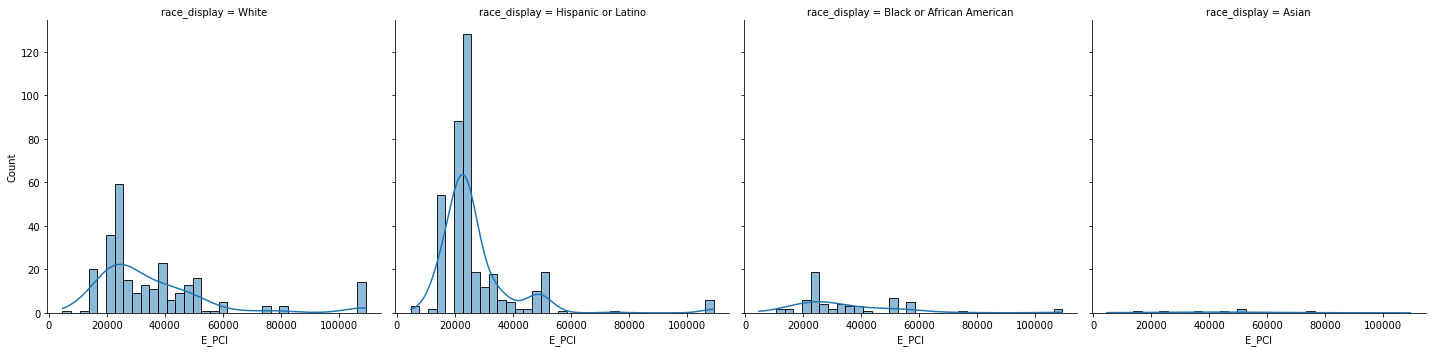

In [ ]:
sns.displot(df_sample, x="E_PCI", col="race_display", multiple="dodge", kde=True)

Text(0.5, 0, 'Per capita income')

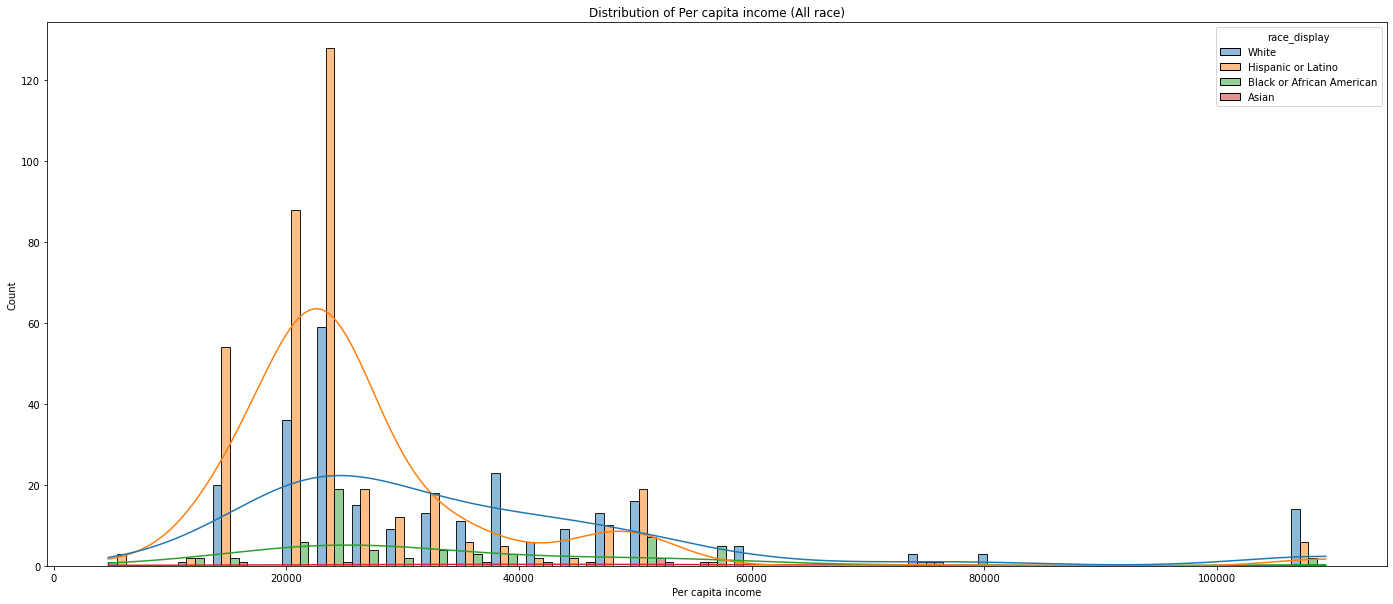

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="E_PCI",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Per capita income (All race)')
plt.xlabel('Per capita income')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'Per capita income')

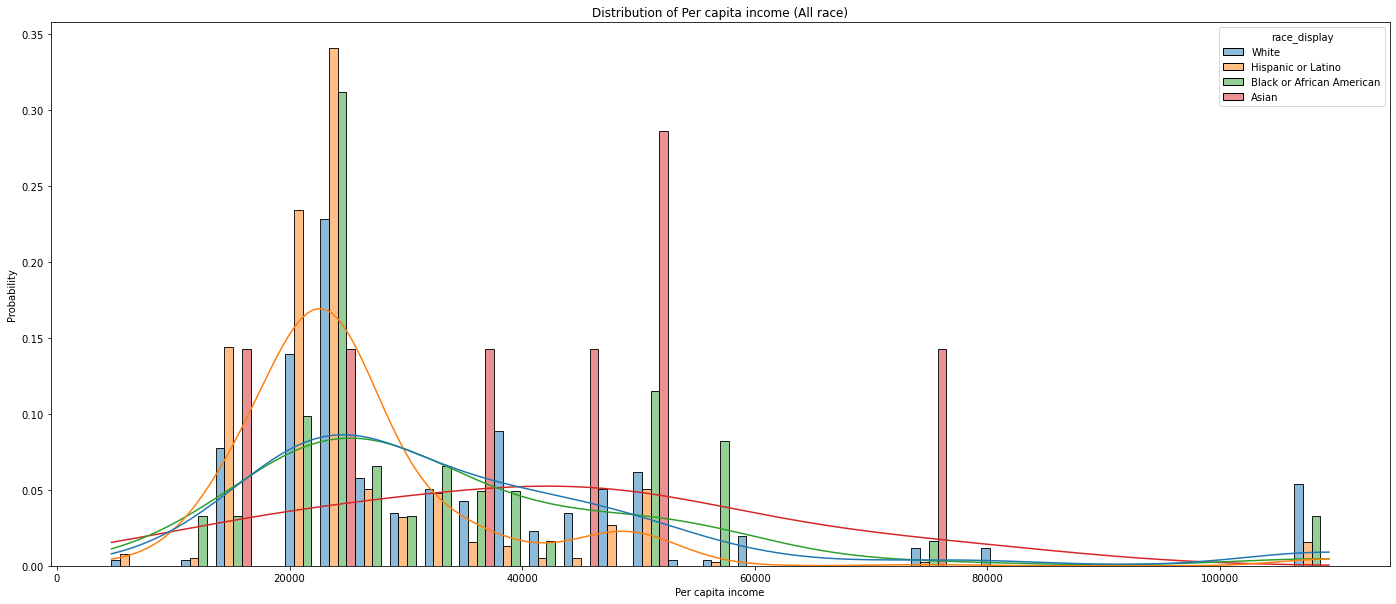

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="E_PCI",
    hue="race_display",
    stat="probability",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Per capita income (All race)')
plt.xlabel('Per capita income')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

### Persons below poverty

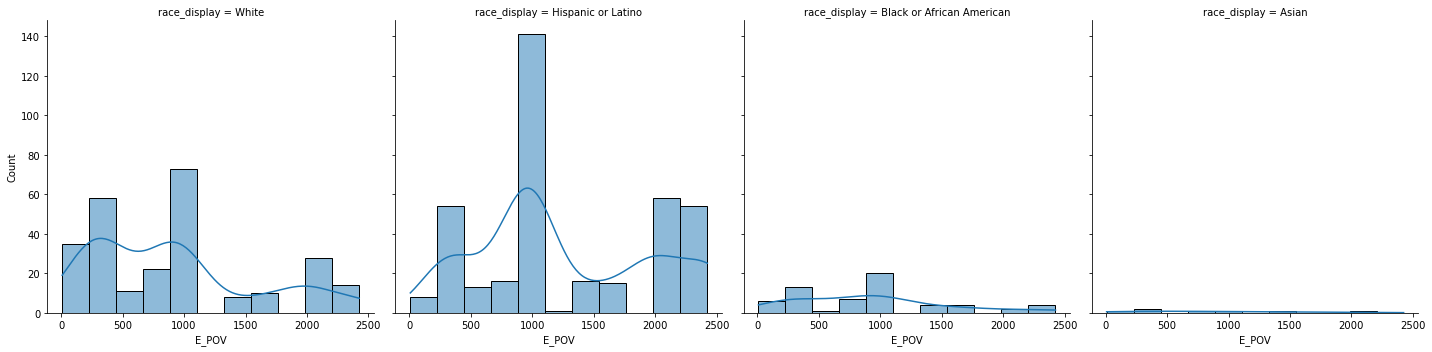

In [ ]:
sns.displot(df_sample, x="E_POV", col="race_display", multiple="dodge", kde=True)

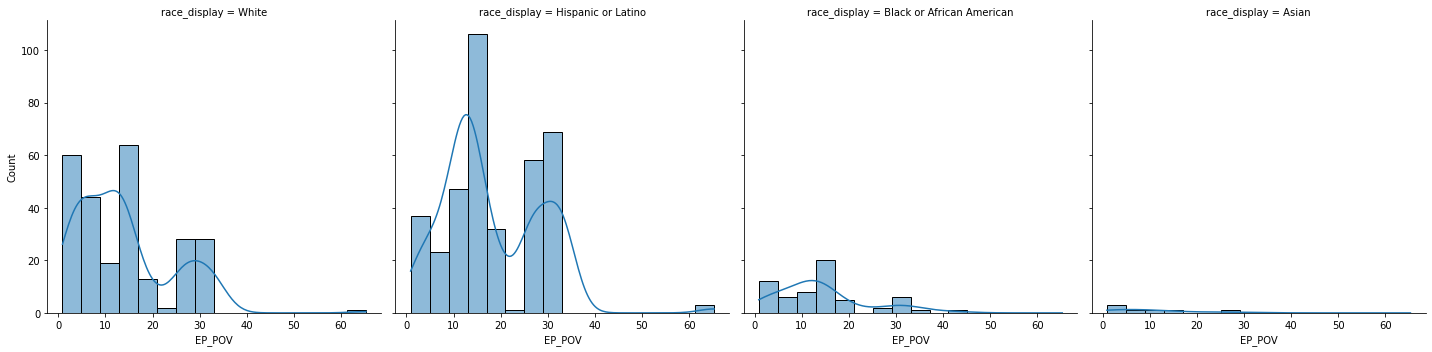

In [ ]:
sns.displot(df_sample, x="EP_POV", col="race_display", multiple="dodge", kde=True)

Text(0.5, 0, 'Persons below poverty')

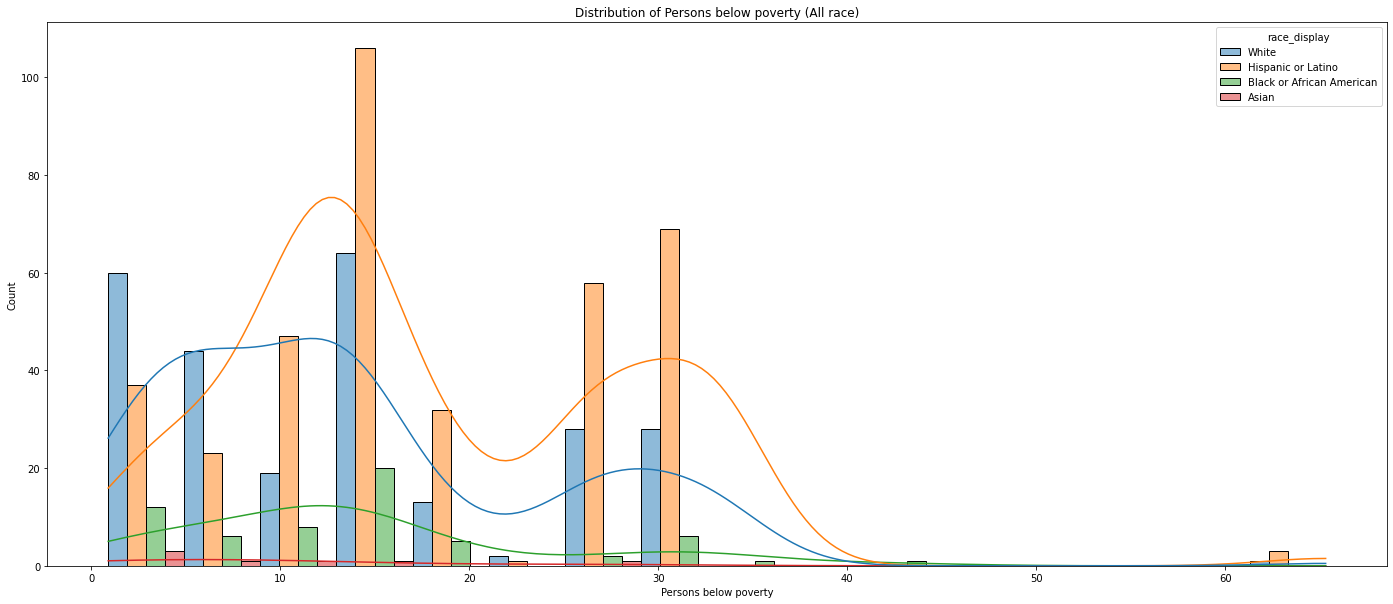

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="EP_POV",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Persons below poverty (All race)')
plt.xlabel('Persons below poverty')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'Persons below poverty')

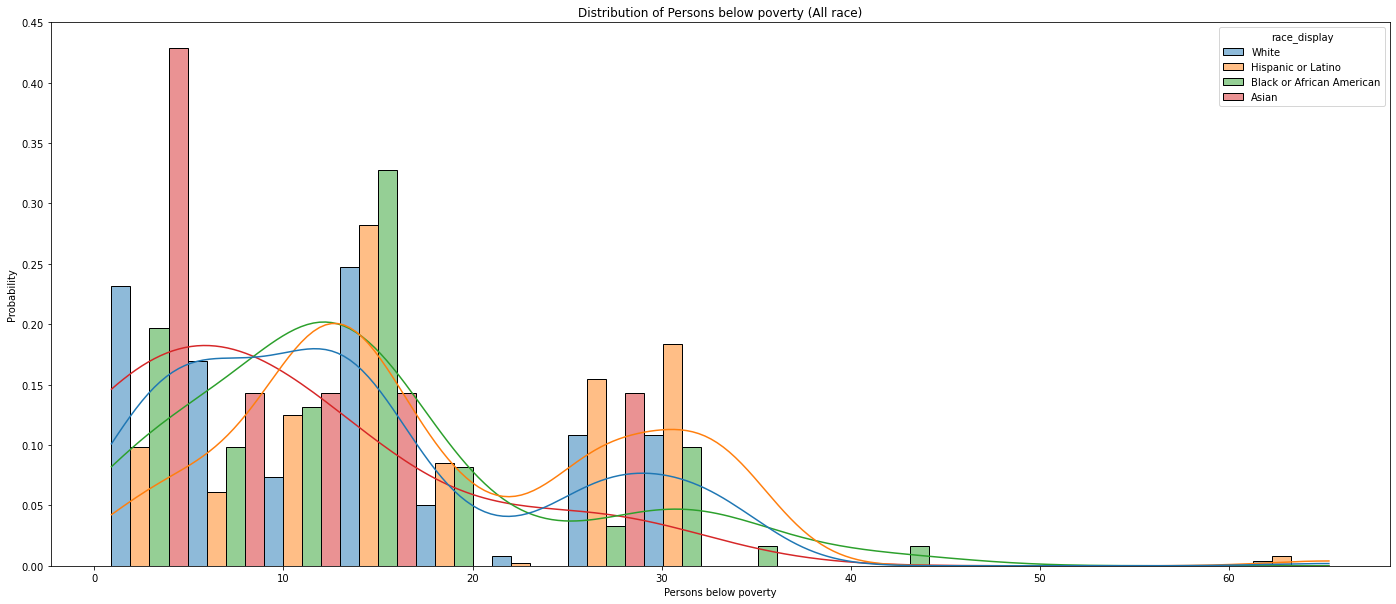

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="EP_POV",
    hue="race_display",
    stat="probability",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Persons below poverty (All race)')
plt.xlabel('Persons below poverty')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

### Civilian (age 16+) unemployed estimate

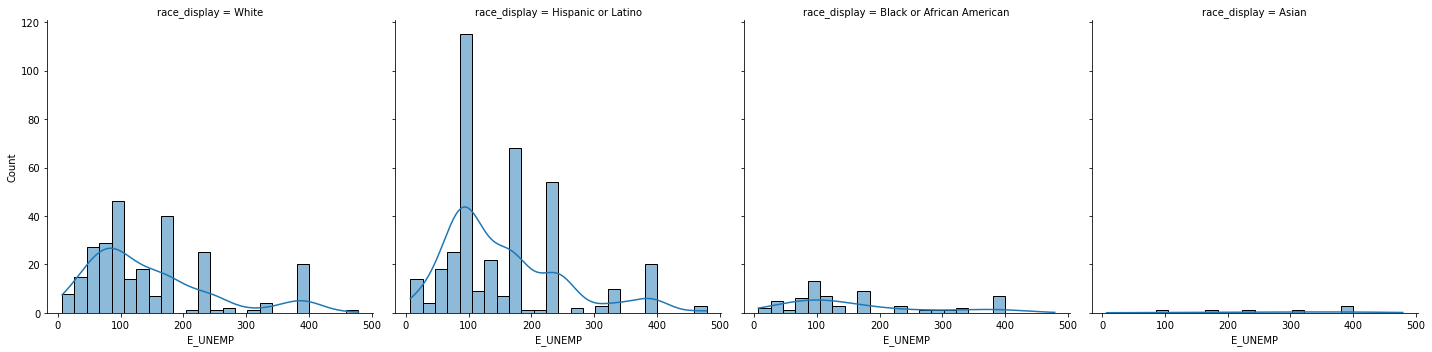

In [ ]:
sns.displot(df_sample, x="E_UNEMP", col="race_display", multiple="dodge", kde=True)

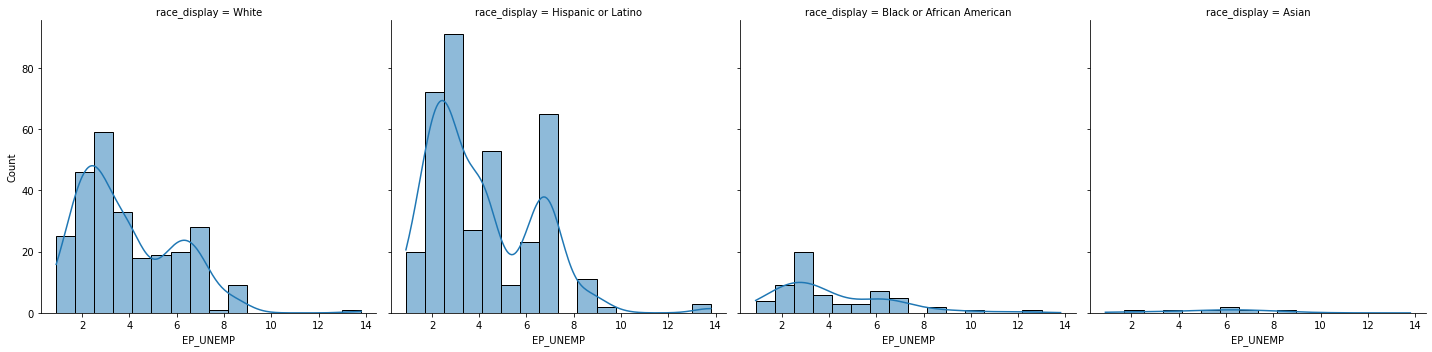

In [ ]:
sns.displot(df_sample, x="EP_UNEMP", col="race_display", multiple="dodge", kde=True)

Text(0.5, 0, 'Civilian (age 16+) unemployed estimate')

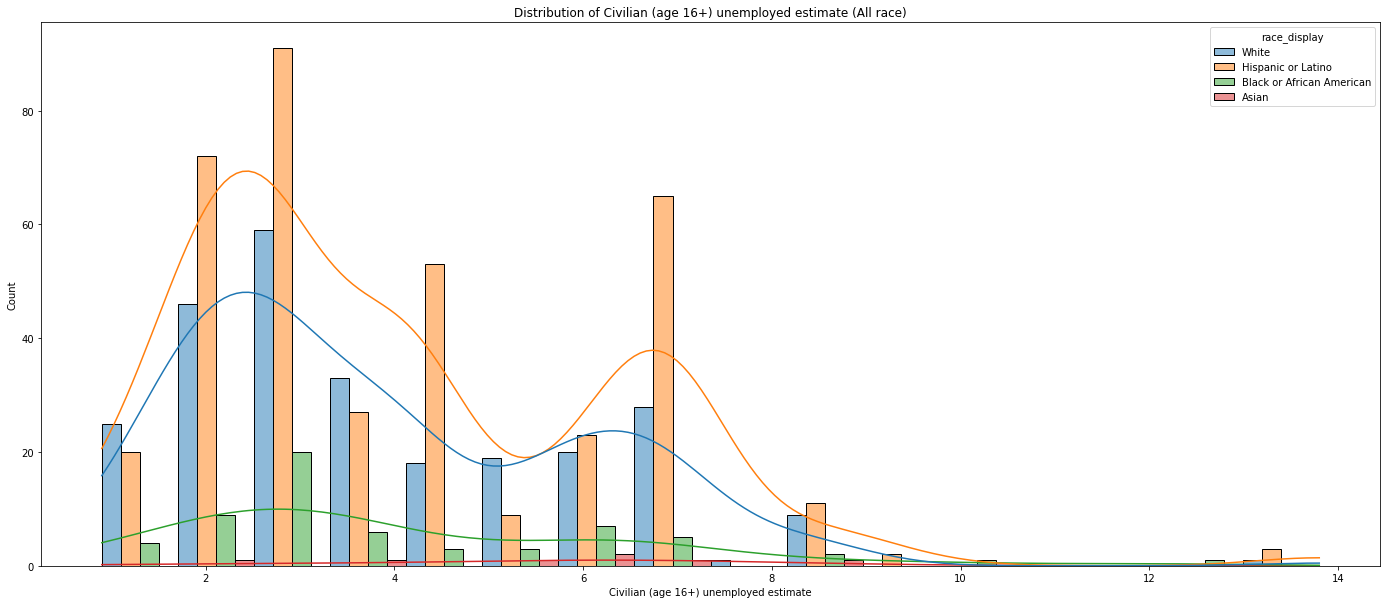

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="EP_UNEMP",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Civilian (age 16+) unemployed estimate (All race)')
plt.xlabel('Civilian (age 16+) unemployed estimate')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

### Persons (age 25+) with no high school diploma estimate

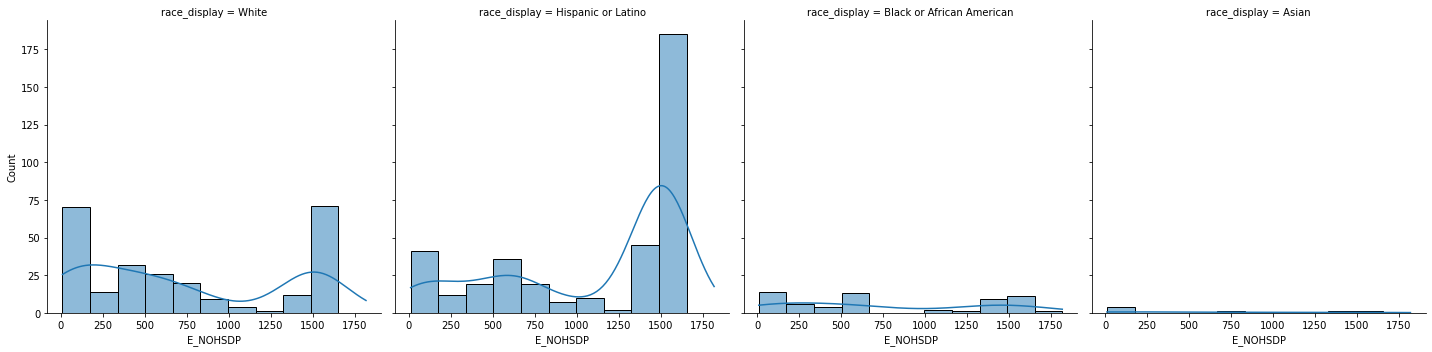

In [ ]:
sns.displot(df_sample, x="E_NOHSDP", col="race_display", multiple="dodge", kde=True)

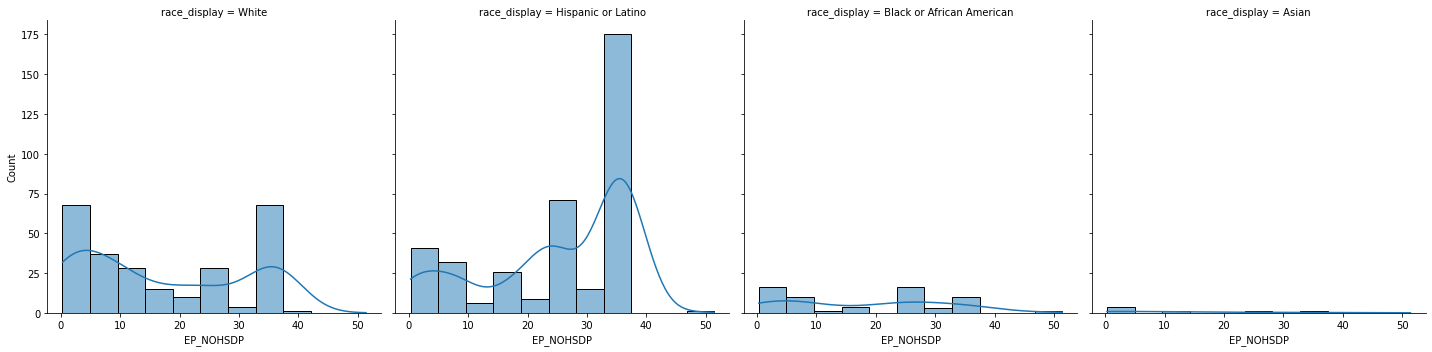

In [ ]:
sns.displot(df_sample, x="EP_NOHSDP", col="race_display", multiple="dodge", kde=True)

Text(0.5, 0, 'Persons (age 25+) with no high school diploma estimate')

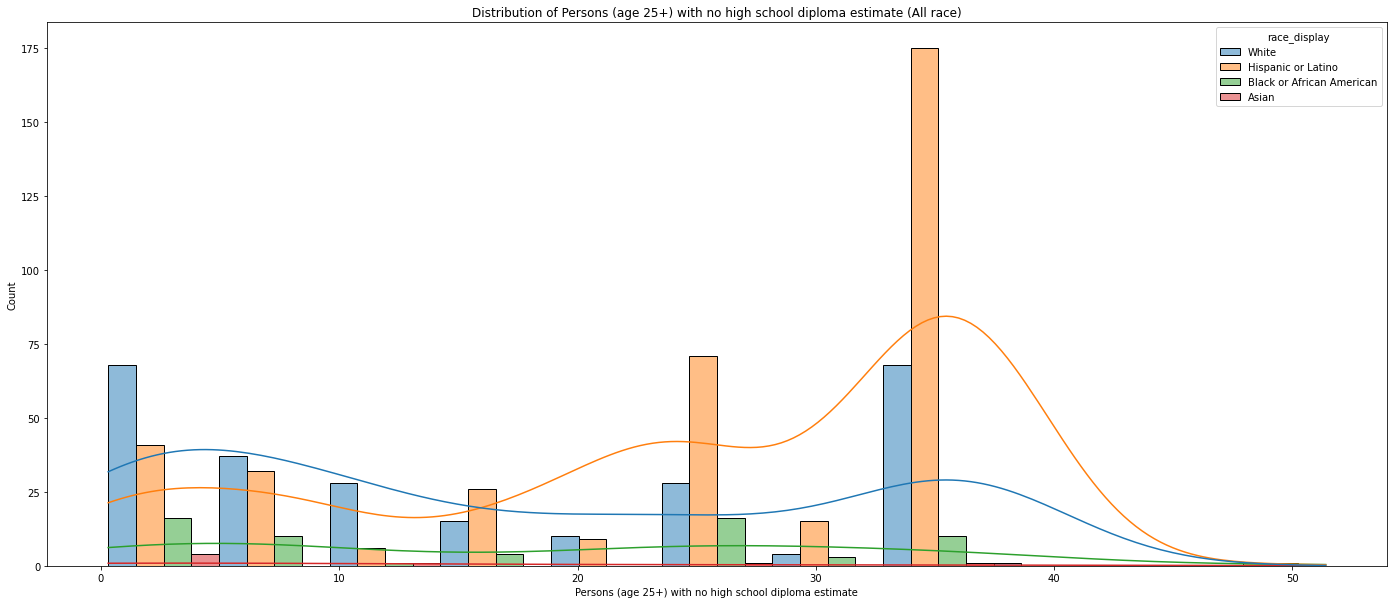

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="EP_NOHSDP",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Persons (age 25+) with no high school diploma estimate (All race)')
plt.xlabel('Persons (age 25+) with no high school diploma estimate')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'TRACT')

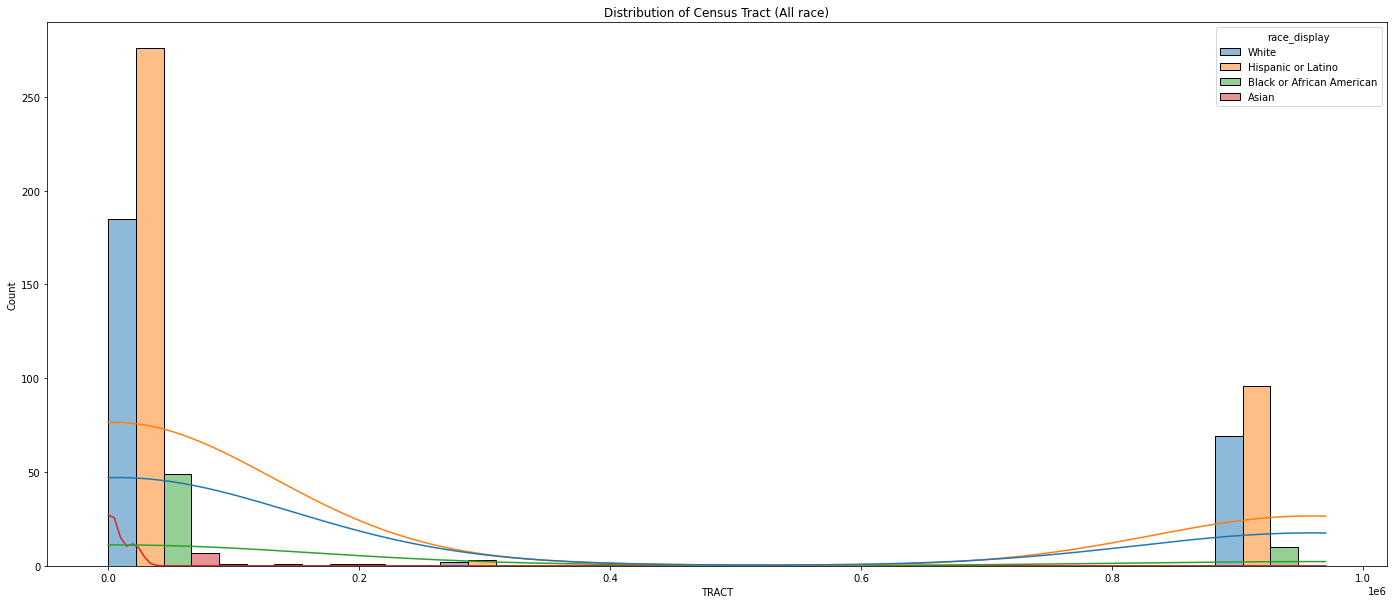

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="TRACT",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Census Tract (All race)')
plt.xlabel('TRACT')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

## F_TOTAL: Sum of flags for the four themes

Text(0.5, 0, 'F_TOTAL')

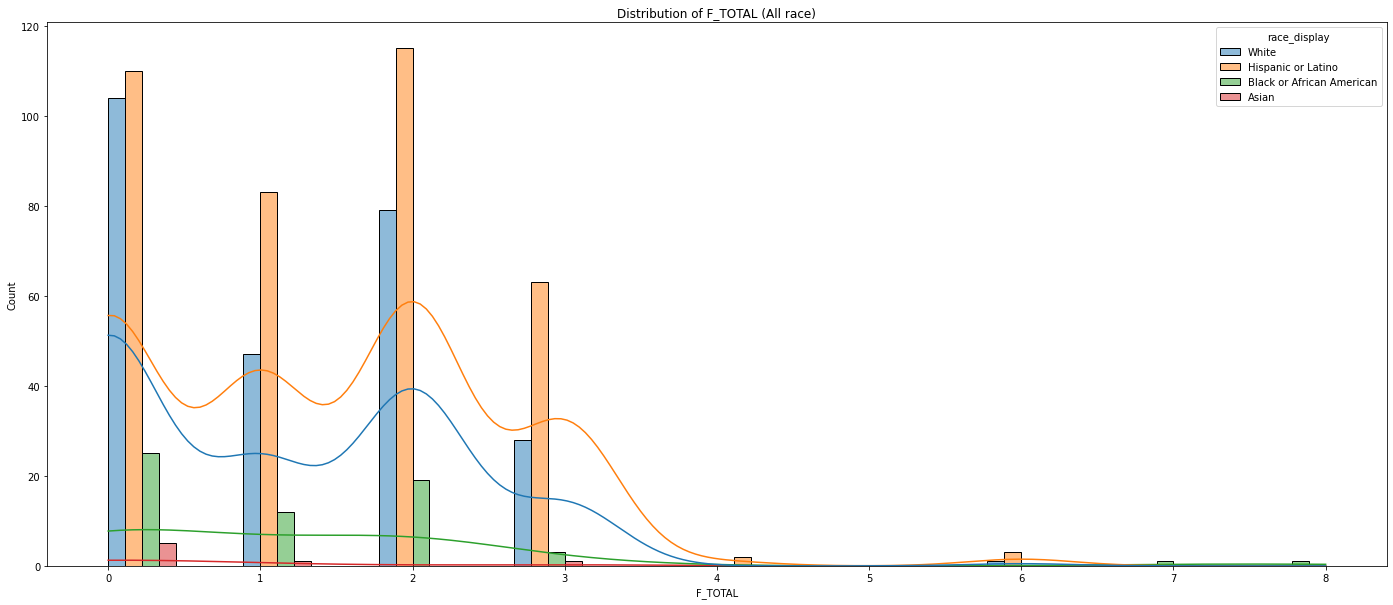

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="F_TOTAL",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of F_TOTAL (All race)')
plt.xlabel('F_TOTAL')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'F_TOTAL')

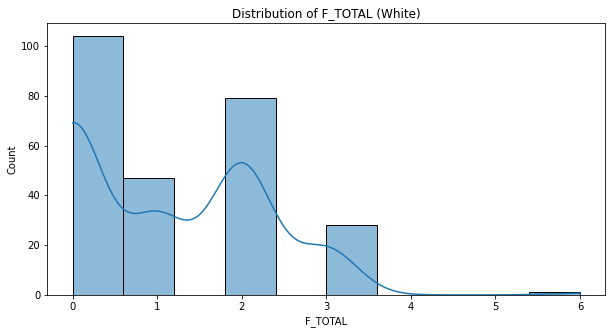

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='White'],
    x="F_TOTAL",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of F_TOTAL (White)')
plt.xlabel('F_TOTAL')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'F_TOTAL')

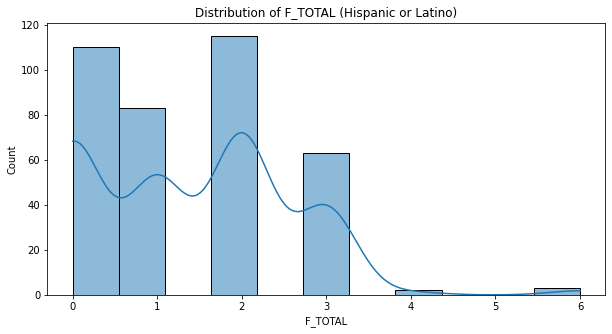

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Hispanic or Latino'],
    x="F_TOTAL",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of F_TOTAL (Hispanic or Latino)')
plt.xlabel('F_TOTAL')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'F_TOTAL')

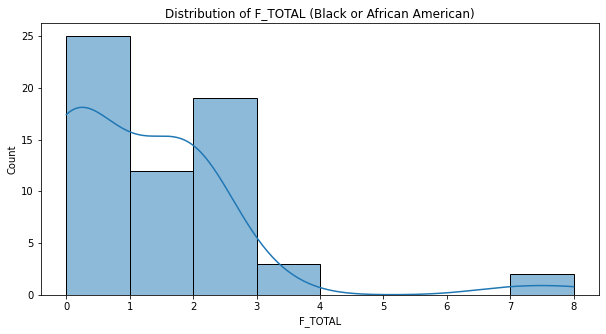

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Black or African American'],
    x="F_TOTAL",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of F_TOTAL (Black or African American)')
plt.xlabel('F_TOTAL')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'F_TOTAL')

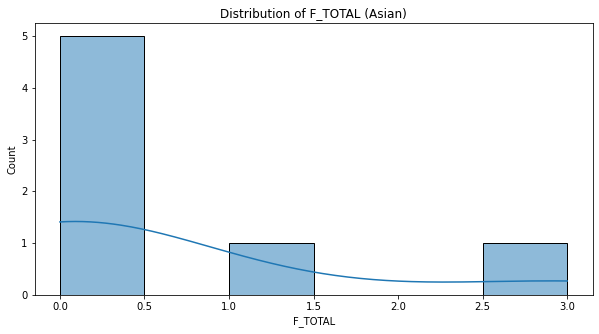

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="F_TOTAL",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of F_TOTAL (Asian)')
plt.xlabel('F_TOTAL')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

/Users/jk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/jk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Race')

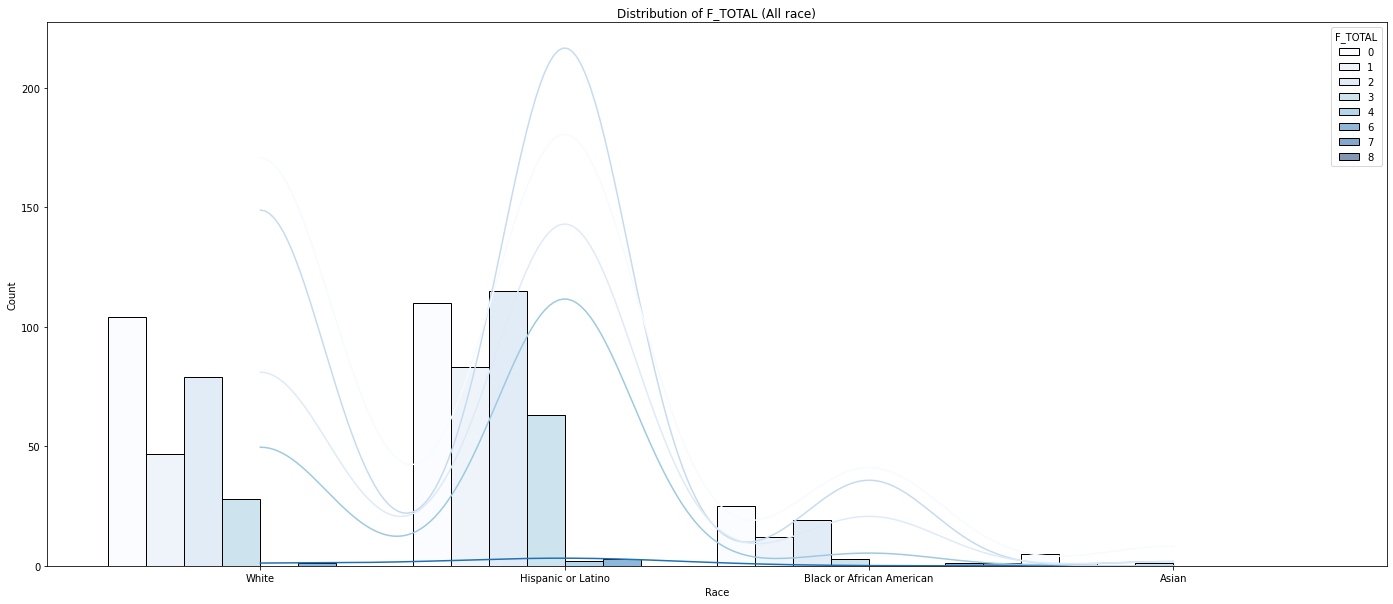

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
#sns.set_palette("pastel")
#sns.color_palette("rocket", as_cmap=True)
sns.histplot(
    df_sample,
    x="race_display",
    hue="F_TOTAL",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True,
    palette='Blues'
)
plt.title('Distribution of F_TOTAL (All race)')
plt.xlabel('Race')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

## RPL_THEMES: Overall percentile ranking

Text(0.5, 0, 'Vulnerability Scores')

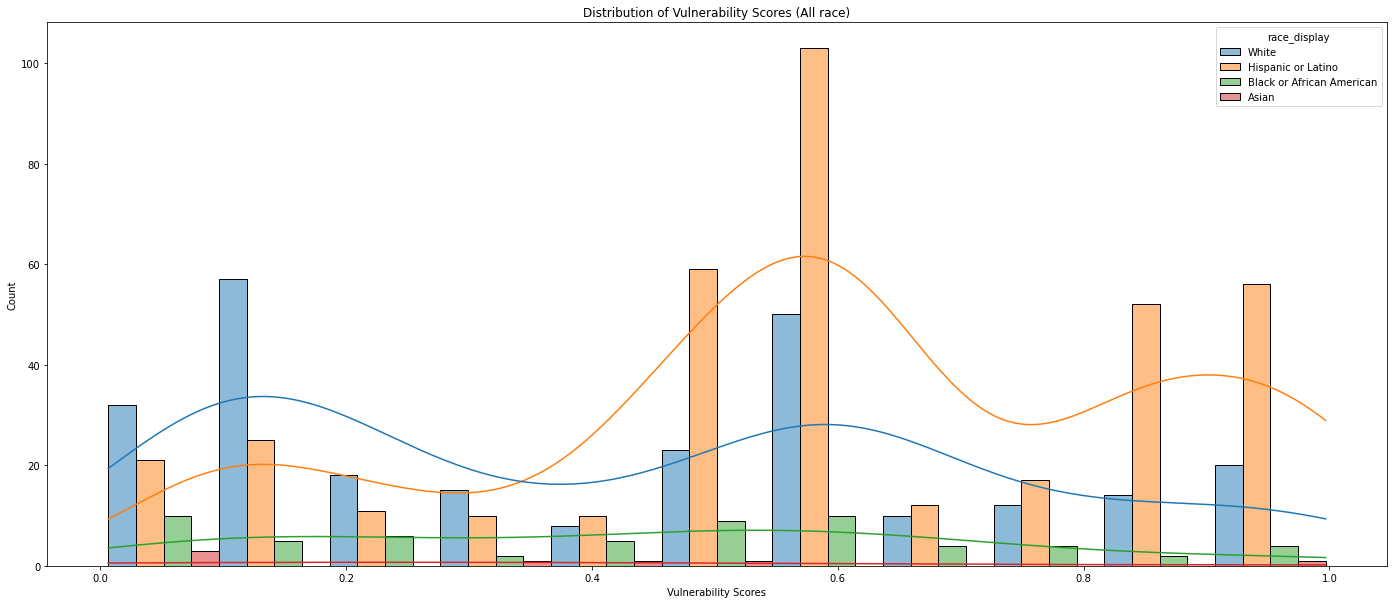

In [ ]:
fig, ax = plt.subplots(figsize=(24,10))
sns.histplot(
    df_sample,
    x="RPL_THEMES",
    hue="race_display",
    #stat="density",
    common_norm=False,
    multiple="dodge",
    kde=True
)
plt.title('Distribution of Vulnerability Scores (All race)')
plt.xlabel('Vulnerability Scores')
#plt.savefig("figures_new/dist_sofa({}).png".format('Total'))

Text(0.5, 0, 'Vulnerability Scores')

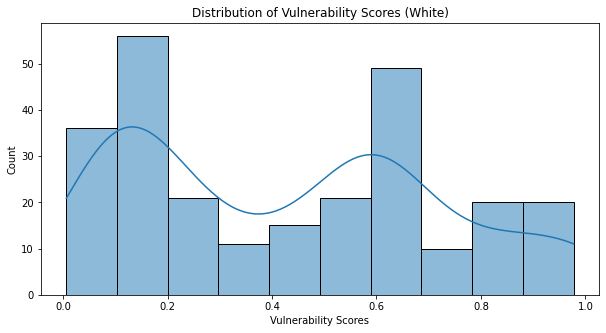

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='White'],
    x="RPL_THEMES",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Vulnerability Scores (White)')
plt.xlabel('Vulnerability Scores')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'Vulnerability Scores')

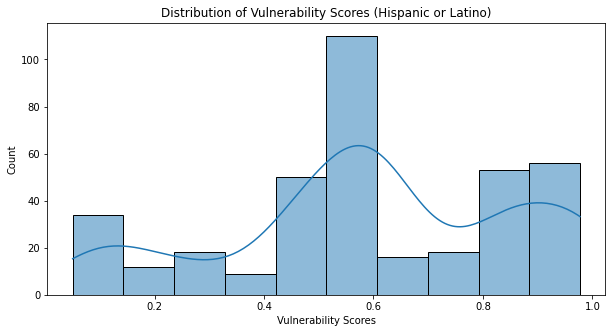

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Hispanic or Latino'],
    x="RPL_THEMES",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Vulnerability Scores (Hispanic or Latino)')
plt.xlabel('Vulnerability Scores')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'Vulnerability Scores')

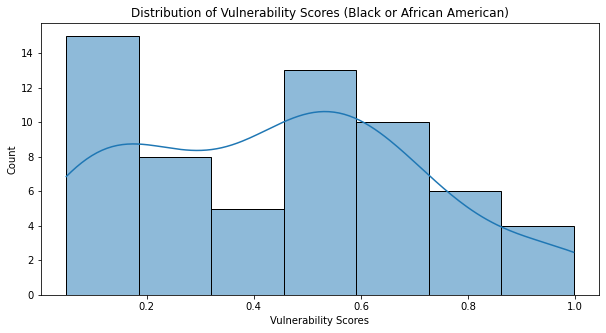

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Black or African American'],
    x="RPL_THEMES",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Vulnerability Scores (Black or African American)')
plt.xlabel('Vulnerability Scores')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))

Text(0.5, 0, 'Vulnerability Scores')

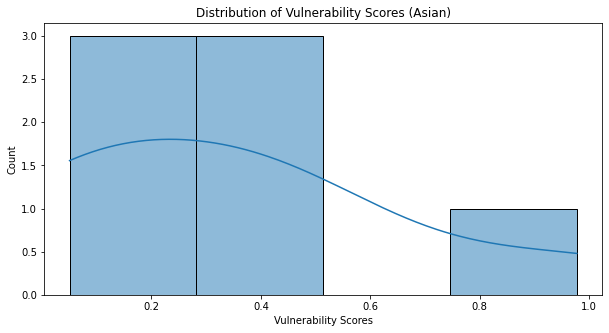

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(
    df_sample.loc[df_sample['race_display']=='Asian'],
    x="RPL_THEMES",
    #stat="density",
    common_norm=False,
    kde=True
)
plt.title('Distribution of Vulnerability Scores (Asian)')
plt.xlabel('Vulnerability Scores')
#plt.savefig("figures_new/dist_sofa({}).png".format('White'))